In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from definitions import *
from helpers import *

In [10]:
movie_metadata      = pd.read_csv(DATASET_PATHS['movie_meta'], sep='\t', names=COL_NAMES['movie_meta'])
character_metadata  = pd.read_csv(DATASET_PATHS['char_meta'], sep='\t', names=COL_NAMES['char_meta'])
plot_summaries      = pd.read_csv(DATASET_PATHS['plot_sum'], sep='\t', names=COL_NAMES['plot_sum'])

# Apply the parse_encoded_col function to relevant columns
movie_metadata['Languages'] = movie_metadata['Languages'].apply(parse_encoded_col)
movie_metadata['Countries'] = movie_metadata['Countries'].apply(parse_encoded_col)
movie_metadata['Genres'] = movie_metadata['Genres'].apply(parse_encoded_col)

# Extract values from the dictionaries (as lists)
movie_metadata['Languages'] = movie_metadata['Languages'].apply(lambda x: list(x.values()))
movie_metadata['Countries'] = movie_metadata['Countries'].apply(lambda x: list(x.values()))
movie_metadata['Genres'] = movie_metadata['Genres'].apply(lambda x: list(x.values()))

# Display the parsed columns
movie_metadata[['Movie name', 'Languages', 'Countries', 'Genres']].head()

# Map the genres for each movie in the DataFrame
movie_metadata['Genres Reduced'] = movie_metadata['Genres'].apply(lambda x: map_genres(x, GENRE_REDUCTION_MAP))

# Dropping all instances with missing gneder since our study is focused around gender
character_metadata = character_metadata.dropna(subset=['Actor gender'])

# Drop the movies with no genres associated
movie_metadata_v2 = movie_metadata[movie_metadata['Genres Reduced'].map(len) > 0]

# Extract the relevant columns from the movie dataset for the merge
movie_glc = movie_metadata_v2[['Freebase movie ID', 'Genres Reduced', 'Languages', 'Countries']]

# Merge the genres with the character dataset on Freebase movie ID
character_metadata_plus = character_metadata.merge(movie_glc, on='Freebase movie ID', how='left')

# Apply the categorization function to the character metadata dataset
character_metadata_plus['Role'] =  character_metadata_plus.apply(lambda row: categorize_character(row, plot_summaries), axis=1)


In [135]:
character_metadata_plus.to_csv('./data/character_metadata_plus.csv', index=False)

In [181]:
sampled_data = character_metadata_plus.sample(frac=0.1, replace=False, random_state=1)

sampled_data.to_csv('./data/sampled_data.csv', index=False)

In [182]:
char_data = pd.read_csv('./data/character_metadata_plus.csv')

char_data = char_data.dropna(subset=['Movie release date'])

# Apply the function to the specified columns
char_data['Genres Reduced'] = char_data['Genres Reduced'].apply(parse_encoded_col)
char_data['Languages'] = char_data['Languages'].apply(parse_encoded_col)
char_data['Countries'] = char_data['Countries'].apply(parse_encoded_col)
char_data['Movie release year'] = pd.to_datetime(char_data['Movie release date'], errors='coerce').dt.year
char_data = char_data.dropna(subset=['Movie release year'])
char_data['Movie release year'] = char_data['Movie release year'].astype(int)

# Display the first few rows after parsing
char_data.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Genres Reduced,Languages,Countries,Role,Movie release year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,"[Adventure, Horror, Action, Western, Thriller,...",[English Language],[United States of America],SC,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,"[Adventure, Horror, Action, Western, Thriller,...",[English Language],[United States of America],SC,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,"[Adventure, Horror, Action, Western, Thriller,...",[English Language],[United States of America],MC,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,"[Adventure, Horror, Action, Western, Thriller,...",[English Language],[United States of America],SC,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,"[Adventure, Horror, Action, Western, Thriller,...",[English Language],[United States of America],SC,2001


In [183]:
# Function to calculate percentage
def calculate_percentage(count_dict):
    total = sum(count_dict.values())
    return {key: np.round((value / total) * 100, 2) for key, value in count_dict.items()}

In [184]:
from collections import Counter
import numpy as np

# Grouping the data by actor's name
grouped_data = char_data.groupby('Freebase actor ID').agg({
    'Actor gender': 'first',
    'Actor height (in meters)': 'first',
    'Actor ethnicity (Freebase ID)': 'first',
    'Actor date of birth': 'first',
    'Genres Reduced': lambda x: Counter([genre for sublist in x for genre in sublist]),
    'Languages': lambda x: Counter([language for sublist in x for language in sublist]),
    'Countries': lambda x: Counter([country for sublist in x for country in sublist]),
    'Movie release year': ['min', 'max', 'count'],
}).reset_index()

grouped_data.columns = [
    'Freebase actor ID', 'Actor gender', 'Actor height (in meters)', 
    'Actor ethnicity (Freebase ID)', 'Actor date of birth', 
    'Genres Reduced', 'Languages', 'Countries', 'First movie year', 
    'Last movie year', 'Total movies'
]

# Applying the function to calculate percentages for genres, languages, and countries
grouped_data['Genres Reduced'] = grouped_data['Genres Reduced'].apply(calculate_percentage)
grouped_data['Languages'] = grouped_data['Languages'].apply(calculate_percentage)
grouped_data['Countries'] = grouped_data['Countries'].apply(calculate_percentage)

grouped_data.head()


,Freebase actor ID,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor date of birth,Genres Reduced,Languages,Countries,First movie year,Last movie year,Total movies
0,/m/010p3,M,1.88,/m/0xnvg,1964-05-27,"{'Animation': 5.56, 'Kids': 2.78, 'Adventure':...","{'English Language': 90.91, 'French Language':...","{'United States of America': 91.67, 'United Ki...",1998,2011,11
1,/m/010q36,M,NaN,None,1928-03-20,"{'Fantasy': 20.0, 'Comedy': 20.0, 'Horror': 20...",{'English Language': 100.0},{'United States of America': 100.0},1995,1995,1
2,/m/010wx,F,1.68,/m/03q819,1977-11-03,{'Short Film': 100.0},{'English Language': 100.0},{'United States of America': 100.0},2003,2003,1
3,/m/010xjr,M,1.85,/m/03bkbh,1930-10-01,"{'Drama': 16.52, 'Women': 1.74, 'Romance': 5.2...","{'English Language': 75.36, 'French Language':...","{'Ireland': 3.06, 'Italy': 9.18, 'West Germany...",1959,2003,54
4,/m/0112yl,M,1.74,None,1920-04-01,"{'Japanese': 13.09, 'Women': 1.09, 'Asian': 12...","{'Japanese Language': 72.92, 'English Language...","{'Japan': 67.27, 'United States of America': 2...",1948,1994,47


In [185]:
def top_three_elements(count_dict, threshold=0.15):
    """
    Function to find the top three elements in a dictionary where each element has a presence 
    of at least {threshold}. If fewer than three elements meet this criterion, fill with NaN.
    """
    # Sorting the dictionary by values in descending order and filtering out elements < 15%
    filtered_items = {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1], reverse=True) if v >= threshold}
    
    # Getting the top three items
    top_items = list(filtered_items.keys())[:3]
    
    # Padding with NaN if fewer than three items are present
    while len(top_items) < 3:
        top_items.append(np.nan)
    
    return top_items


In [186]:
# Applying the function to calculate top three genres, languages, and countries
grouped_data['Top 3 Genres'] = grouped_data['Genres Reduced'].apply(top_three_elements)
grouped_data['Top 3 Languages'] = grouped_data['Languages'].apply(top_three_elements)
grouped_data['Top 3 Countries'] = grouped_data['Countries'].apply(top_three_elements)

# Splitting the top 3 items into separate columns
grouped_data[['Genre 1', 'Genre 2', 'Genre 3']] = pd.DataFrame(grouped_data['Top 3 Genres'].tolist(), index=grouped_data.index)
grouped_data[['Language 1', 'Language 2', 'Language 3']] = pd.DataFrame(grouped_data['Top 3 Languages'].tolist(), index=grouped_data.index)
grouped_data[['Country 1', 'Country 2', 'Country 3']] = pd.DataFrame(grouped_data['Top 3 Countries'].tolist(), index=grouped_data.index)

# Dropping the original 'Top 3' columns
grouped_data.drop(['Top 3 Genres', 'Top 3 Languages', 'Top 3 Countries'], axis=1, inplace=True)

grouped_data.head()

,Freebase actor ID,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor date of birth,Genres Reduced,Languages,Countries,First movie year,Last movie year,Total movies,Genre 1,Genre 2,Genre 3,Language 1,Language 2,Language 3,Country 1,Country 2,Country 3
0,/m/010p3,M,1.88,/m/0xnvg,1964-05-27,"{'Animation': 5.56, 'Kids': 2.78, 'Adventure':...","{'English Language': 90.91, 'French Language':...","{'United States of America': 91.67, 'United Ki...",1998,2011,11,Comedy,Romance,Independent,English Language,French Language,NaN,United States of America,United Kingdom,NaN
1,/m/010q36,M,NaN,None,1928-03-20,"{'Fantasy': 20.0, 'Comedy': 20.0, 'Horror': 20...",{'English Language': 100.0},{'United States of America': 100.0},1995,1995,1,Fantasy,Comedy,Horror,English Language,NaN,NaN,United States of America,NaN,NaN
2,/m/010wx,F,1.68,/m/03q819,1977-11-03,{'Short Film': 100.0},{'English Language': 100.0},{'United States of America': 100.0},2003,2003,1,Short Film,NaN,NaN,English Language,NaN,NaN,United States of America,NaN,NaN
3,/m/010xjr,M,1.85,/m/03bkbh,1930-10-01,"{'Drama': 16.52, 'Women': 1.74, 'Romance': 5.2...","{'English Language': 75.36, 'French Language':...","{'Ireland': 3.06, 'Italy': 9.18, 'West Germany...",1959,2003,54,Drama,Adventure,Action,English Language,French Language,German Language,United States of America,United Kingdom,Italy
4,/m/0112yl,M,1.74,None,1920-04-01,"{'Japanese': 13.09, 'Women': 1.09, 'Asian': 12...","{'Japanese Language': 72.92, 'English Language...","{'Japan': 67.27, 'United States of America': 2...",1948,1994,47,Drama,Japanese,Asian,Japanese Language,English Language,Spanish Language,Japan,United States of America,United Kingdom


In [187]:
data_v2 = pd.read_csv('./data/grouped_data.csv')

data_v2.head()

,Actor name,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor date of birth,Genres Reduced,Languages,Countries,First movie year,Last movie year,...,Genre 3,Language 1,Language 2,Language 3,Country 1,Country 2,Country 3,Top 3 Genres,Top 3 Languages,Top 3 Countries
0,Cesarine Prinz\t,F,NaN,NaN,1883.0,"{'Comedy': 50.0, 'Silent': 50.0}",{},{'Netherlands': 100.0},1922,1926,...,NaN,NaN,NaN,NaN,Netherlands,NaN,NaN,"['Comedy', 'Silent']",[],['Netherlands']
1,Daniel Newman,M,NaN,NaN,1976.0,"{'Science Fiction': 50.0, 'Drama': 50.0}",{'English Language': 100.0},"{'United States of America': 33.33, 'Canada': ...",1998,1998,...,NaN,English Language,NaN,NaN,United States of America,Canada,Luxembourg,"['Science Fiction', 'Drama']",['English Language'],"['United States of America', 'Canada', 'Luxemb..."
2,'Big Bill' Giddinger,M,NaN,NaN,NaN,"{'Independent': 20.0, 'Western': 20.0, 'Silent...",{'English Language': 100.0},{'United States of America': 100.0},1911,1911,...,Silent,English Language,NaN,NaN,United States of America,NaN,NaN,"['Independent', 'Western', 'Silent']",['English Language'],['United States of America']
3,'Big' Lee,M,NaN,NaN,NaN,"{'Drama': 25.0, 'Crime': 25.0, 'Fiction': 25.0...",{'English Language': 100.0},{'United States of America': 100.0},1973,1973,...,Fiction,English Language,NaN,NaN,United States of America,NaN,NaN,"['Drama', 'Crime', 'Fiction']",['English Language'],['United States of America']
4,'Crazy George' Henderson,M,NaN,NaN,NaN,"{'Science Fiction': 33.33, 'Horror': 33.33, 'T...",{'English Language': 100.0},{'United States of America': 100.0},1975,1975,...,Thriller,English Language,NaN,NaN,United States of America,NaN,NaN,"['Science Fiction', 'Horror', 'Thriller']",['English Language'],['United States of America']


In [188]:
grouped_data.head()

,Freebase actor ID,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor date of birth,Genres Reduced,Languages,Countries,First movie year,Last movie year,Total movies,Genre 1,Genre 2,Genre 3,Language 1,Language 2,Language 3,Country 1,Country 2,Country 3
0,/m/010p3,M,1.88,/m/0xnvg,1964-05-27,"{'Animation': 5.56, 'Kids': 2.78, 'Adventure':...","{'English Language': 90.91, 'French Language':...","{'United States of America': 91.67, 'United Ki...",1998,2011,11,Comedy,Romance,Independent,English Language,French Language,NaN,United States of America,United Kingdom,NaN
1,/m/010q36,M,NaN,None,1928-03-20,"{'Fantasy': 20.0, 'Comedy': 20.0, 'Horror': 20...",{'English Language': 100.0},{'United States of America': 100.0},1995,1995,1,Fantasy,Comedy,Horror,English Language,NaN,NaN,United States of America,NaN,NaN
2,/m/010wx,F,1.68,/m/03q819,1977-11-03,{'Short Film': 100.0},{'English Language': 100.0},{'United States of America': 100.0},2003,2003,1,Short Film,NaN,NaN,English Language,NaN,NaN,United States of America,NaN,NaN
3,/m/010xjr,M,1.85,/m/03bkbh,1930-10-01,"{'Drama': 16.52, 'Women': 1.74, 'Romance': 5.2...","{'English Language': 75.36, 'French Language':...","{'Ireland': 3.06, 'Italy': 9.18, 'West Germany...",1959,2003,54,Drama,Adventure,Action,English Language,French Language,German Language,United States of America,United Kingdom,Italy
4,/m/0112yl,M,1.74,None,1920-04-01,"{'Japanese': 13.09, 'Women': 1.09, 'Asian': 12...","{'Japanese Language': 72.92, 'English Language...","{'Japan': 67.27, 'United States of America': 2...",1948,1994,47,Drama,Japanese,Asian,Japanese Language,English Language,Spanish Language,Japan,United States of America,United Kingdom


In [189]:
def none_to_nan(data):
    if data is None:
        return np.nan
    else:
        return data
    
# Applying the function to the specified columns
grouped_data['Actor ethnicity (Freebase ID)'] = grouped_data['Actor ethnicity (Freebase ID)'].apply(none_to_nan)
grouped_data['Actor date of birth'] = grouped_data['Actor date of birth'].apply(none_to_nan)

In [190]:
# select only the year of birth if it exists
def extract_year(date_string):
    if date_string is np.nan:
        return np.nan
    else:
        return int(date_string.split('-')[0])
    
# Apply the function to the Actor date of birth column
grouped_data['Actor date of birth'] = grouped_data['Actor date of birth'].apply(extract_year)


In [191]:
grouped_data.head()

,Freebase actor ID,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor date of birth,Genres Reduced,Languages,Countries,First movie year,Last movie year,Total movies,Genre 1,Genre 2,Genre 3,Language 1,Language 2,Language 3,Country 1,Country 2,Country 3
0,/m/010p3,M,1.88,/m/0xnvg,1964.0,"{'Animation': 5.56, 'Kids': 2.78, 'Adventure':...","{'English Language': 90.91, 'French Language':...","{'United States of America': 91.67, 'United Ki...",1998,2011,11,Comedy,Romance,Independent,English Language,French Language,NaN,United States of America,United Kingdom,NaN
1,/m/010q36,M,NaN,NaN,1928.0,"{'Fantasy': 20.0, 'Comedy': 20.0, 'Horror': 20...",{'English Language': 100.0},{'United States of America': 100.0},1995,1995,1,Fantasy,Comedy,Horror,English Language,NaN,NaN,United States of America,NaN,NaN
2,/m/010wx,F,1.68,/m/03q819,1977.0,{'Short Film': 100.0},{'English Language': 100.0},{'United States of America': 100.0},2003,2003,1,Short Film,NaN,NaN,English Language,NaN,NaN,United States of America,NaN,NaN
3,/m/010xjr,M,1.85,/m/03bkbh,1930.0,"{'Drama': 16.52, 'Women': 1.74, 'Romance': 5.2...","{'English Language': 75.36, 'French Language':...","{'Ireland': 3.06, 'Italy': 9.18, 'West Germany...",1959,2003,54,Drama,Adventure,Action,English Language,French Language,German Language,United States of America,United Kingdom,Italy
4,/m/0112yl,M,1.74,NaN,1920.0,"{'Japanese': 13.09, 'Women': 1.09, 'Asian': 12...","{'Japanese Language': 72.92, 'English Language...","{'Japan': 67.27, 'United States of America': 2...",1948,1994,47,Drama,Japanese,Asian,Japanese Language,English Language,Spanish Language,Japan,United States of America,United Kingdom


In [193]:
# Make new dataframe with only the relevant columns
columns = [
    'Freebase actor ID',
    'Actor gender',
    'Actor date of birth',
    'Actor height (in meters)',
    'Actor ethnicity (Freebase ID)',
    'First movie year',
    'Last movie year',
    'Total movies',
    'Genre 1',
    'Genre 2',
    'Genre 3',
    'Language 1',
    'Language 2',
    'Language 3',
    'Country 1',
    'Country 2',
    'Country 3'
]

grouped_data = grouped_data[columns]

grouped_data.head()

    

,Freebase actor ID,Actor gender,Actor date of birth,Actor height (in meters),Actor ethnicity (Freebase ID),First movie year,Last movie year,Total movies,Genre 1,Genre 2,Genre 3,Language 1,Language 2,Language 3,Country 1,Country 2,Country 3
0,/m/010p3,M,1964.0,1.88,/m/0xnvg,1998,2011,11,Comedy,Romance,Independent,English Language,French Language,NaN,United States of America,United Kingdom,NaN
1,/m/010q36,M,1928.0,NaN,NaN,1995,1995,1,Fantasy,Comedy,Horror,English Language,NaN,NaN,United States of America,NaN,NaN
2,/m/010wx,F,1977.0,1.68,/m/03q819,2003,2003,1,Short Film,NaN,NaN,English Language,NaN,NaN,United States of America,NaN,NaN
3,/m/010xjr,M,1930.0,1.85,/m/03bkbh,1959,2003,54,Drama,Adventure,Action,English Language,French Language,German Language,United States of America,United Kingdom,Italy
4,/m/0112yl,M,1920.0,1.74,NaN,1948,1994,47,Drama,Japanese,Asian,Japanese Language,English Language,Spanish Language,Japan,United States of America,United Kingdom


In [194]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96991 entries, 0 to 96990
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Freebase actor ID              96991 non-null  object 
 1   Actor gender                   96991 non-null  object 
 2   Actor date of birth            57180 non-null  float64
 3   Actor height (in meters)       12692 non-null  float64
 4   Actor ethnicity (Freebase ID)  8080 non-null   object 
 5   First movie year               96991 non-null  int32  
 6   Last movie year                96991 non-null  int32  
 7   Total movies                   96991 non-null  int64  
 8   Genre 1                        96494 non-null  object 
 9   Genre 2                        84921 non-null  object 
 10  Genre 3                        72011 non-null  object 
 11  Language 1                     93647 non-null  object 
 12  Language 2                     31400 non-null 

In [195]:
def clean_surrogate_characters(df):
    """
    Function to clean surrogate characters from a DataFrame.
    It iterates over each column and each string, replacing surrogate characters.
    """
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].apply(lambda x: x.encode('utf-16', 'surrogatepass').decode('utf-16') if isinstance(x, str) else x)
    return df

# Cleaning the DataFrame
cleaned_grouped_data = clean_surrogate_characters(grouped_data.copy())

# Calculate the career length for each actor
cleaned_grouped_data['Career Length'] = cleaned_grouped_data['Last movie year'] - cleaned_grouped_data['First movie year']

# Define the reference year as the maximum 'Last movie year' in the dataset
reference_year = cleaned_grouped_data['Last movie year'].max()

# Apply the censoring heuristic: if 'Last movie year' is within the last 10 years from the reference year,
# the actor is censored (1); otherwise, they are not (0).
cleaned_grouped_data['Censored'] = (reference_year - cleaned_grouped_data['Last movie year'] >= 10).astype(int)

# Exporting the cleaned DataFrame to a CSV file
cleaned_grouped_data.to_csv('./data/surv_data.csv', index=False)

# Survival Analysis

### Dataset Desription
The dataset contains various attributes related to actors and their careers. Here's a summary of the columns present:

1. **Freebase Actor ID**: A unique identifier for each actor.
2. **Actor Gender**: The gender of the actor (M/F).
3. **Actor Date of Birth**: The year of birth of the actor.
4. **Actor Height (in meters)**: The height of the actor in meters.
5. **Actor Ethnicity (Freebase ID)**: An identifier for the actor's ethnicity.
6. **First Movie Year**: The year when the actor's first movie was released.
7. **Last Movie Year**: The year when the actor's last movie was released.
8. **Total Movies**: The total number of movies the actor has been in.
9. **Genre 1, Genre 2, Genre 3**: The top three genres in which the actor has worked.
10. **Language 1, Language 2, Language 3**: The top three languages of the movies the actor has worked in.
11. **Country 1, Country 2, Country 3**: The top three countries associated with the movies the actor has worked in.
12. **Career Length**: The length of the actor's career in years.
13. **Censored**: Indicates whether the actor's career length is censored (1) or not (0).

In [199]:
data = pd.read_csv('./data/surv_data.csv')

data.head()

,Freebase actor ID,Actor gender,Actor date of birth,Actor height (in meters),Actor ethnicity (Freebase ID),First movie year,Last movie year,Total movies,Genre 1,Genre 2,Genre 3,Language 1,Language 2,Language 3,Country 1,Country 2,Country 3,Career Length,Censored
0,/m/010p3,M,1964.0,1.88,/m/0xnvg,1998,2011,11,Comedy,Romance,Independent,English Language,French Language,NaN,United States of America,United Kingdom,NaN,13,0
1,/m/010q36,M,1928.0,NaN,NaN,1995,1995,1,Fantasy,Comedy,Horror,English Language,NaN,NaN,United States of America,NaN,NaN,0,1
2,/m/010wx,F,1977.0,1.68,/m/03q819,2003,2003,1,Short Film,NaN,NaN,English Language,NaN,NaN,United States of America,NaN,NaN,0,1
3,/m/010xjr,M,1930.0,1.85,/m/03bkbh,1959,2003,54,Drama,Adventure,Action,English Language,French Language,German Language,United States of America,United Kingdom,Italy,44,1
4,/m/0112yl,M,1920.0,1.74,NaN,1948,1994,47,Drama,Japanese,Asian,Japanese Language,English Language,Spanish Language,Japan,United States of America,United Kingdom,46,1


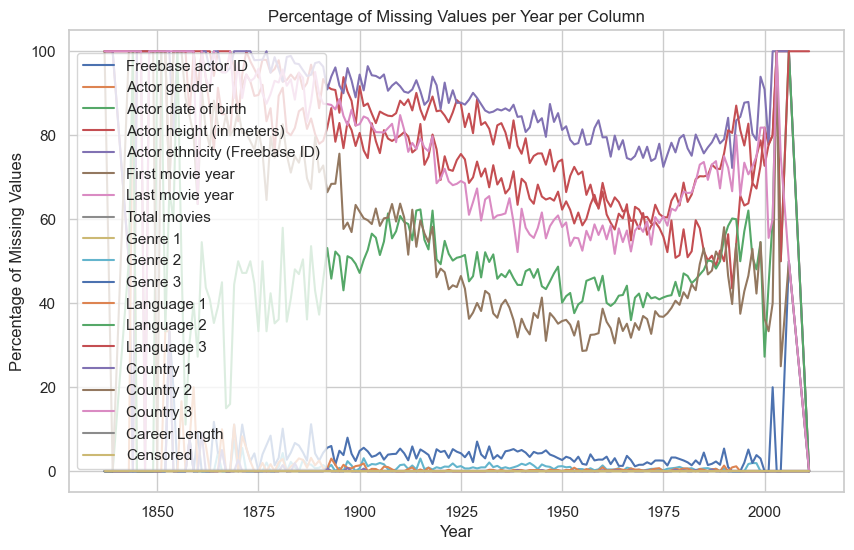

In [273]:
# Percentage of missing values each year per column

missing_per_year = data[data['Actor date of birth'] > 1800].groupby('Actor date of birth').apply(lambda x: x.isnull().sum() / len(x) * 100)

# Plotting the missing values per year per column
plt.figure(figsize=(10, 6))
for column in missing_per_year.columns:
    plt.plot(missing_per_year.index, missing_per_year[column], label=column)

plt.title('Percentage of Missing Values per Year per Column')
plt.xlabel('Year')
plt.ylabel('Percentage of Missing Values')
plt.legend()
plt.show()

## Expolatory Data Analysis

### Univariate Analysis

#### Career Length

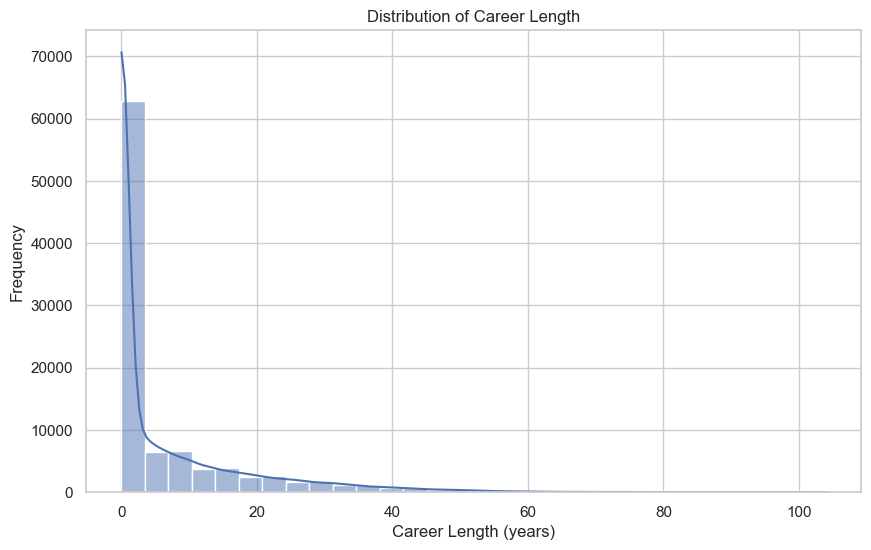

count    96991.000000
mean         6.305142
std         11.091589
min          0.000000
25%          0.000000
50%          0.000000
75%          8.000000
max        104.000000
Name: Career Length, dtype: float64

In [207]:
# Descriptive Statistics for 'Career Length'
career_length_stats = data['Career Length'].describe()

# Histogram for 'Career Length'
plt.figure(figsize=(10, 6))
sns.histplot(data['Career Length'], kde=True, bins=30)
plt.title('Distribution of Career Length')
plt.xlabel('Career Length (years)')
plt.ylabel('Frequency')
plt.show()

career_length_stats

1. **Descriptive Statistics**: Providing a detailed summary of the variable.
2. **Histogram**: Visualizing the distribution of the "Career Length" variable.

We'll start by examining the descriptive statistics to get a sense of the central tendency, spread, and overall distribution, and then we'll look at the histogram for a visual representation of the distribution. Let's proceed with the analysis of the "Career Length" variable.

The univariate analysis for "Career Length" yields the following insights:

### Descriptive Statistics:
- **Count**: 96,991 observations.
- **Mean**: The average career length is approximately 6.31 years.
- **Standard Deviation**: There is a significant spread in the data, with a standard deviation of about 11.09 years.
- **Minimum**: The shortest career length is 0 years.
- **25th Percentile**: 25% of actors have a career length of 0 years.
- **Median (50th Percentile)**: Half of the actors have a career length of 0 years, indicating a large number of actors with very short careers.
- **75th Percentile**: 75% of actors have a career length of 8 years or less.
- **Maximum**: The longest career length is 104 years.

### Histogram:
- The histogram shows a highly skewed distribution, with a large number of actors having very short careers (many at 0 years).
- There are fewer actors with longer careers, as indicated by the long tail extending to the right.

This analysis suggests that the acting profession, as represented in this dataset, is characterized by a large number of individuals with very brief careers, and a smaller number of actors with long, sustained careers. The skewness and the concentration of data at the lower end (short careers) are notable features of this distribution.



Due to the large number of actors with short careers, the histogram is not very informative. So we will be performing the survival analysis on a subset of the data, containing only actors with careers longer than 1 year. And the actors with short careers will be considered in later analysis individually.

In [211]:
# Filtering out careers of less than a year
data_1 = data[data['Career Length'] >= 1]

# Creating a new dataframe for analysis later
data_0 = data[data['Career Length'] < 1]

# Display the first few rows of the new dataframe for longer careers
data_1.head()



,Freebase actor ID,Actor gender,Actor date of birth,Actor height (in meters),Actor ethnicity (Freebase ID),First movie year,Last movie year,Total movies,Genre 1,Genre 2,Genre 3,Language 1,Language 2,Language 3,Country 1,Country 2,Country 3,Career Length,Censored
0,/m/010p3,M,1964.0,1.88,/m/0xnvg,1998,2011,11,Comedy,Romance,Independent,English Language,French Language,NaN,United States of America,United Kingdom,NaN,13,0
3,/m/010xjr,M,1930.0,1.85,/m/03bkbh,1959,2003,54,Drama,Adventure,Action,English Language,French Language,German Language,United States of America,United Kingdom,Italy,44,1
4,/m/0112yl,M,1920.0,1.74,NaN,1948,1994,47,Drama,Japanese,Asian,Japanese Language,English Language,Spanish Language,Japan,United States of America,United Kingdom,46,1
6,/m/011_24,M,1912.0,NaN,NaN,1942,1963,2,Comedy,Romance,Science Fiction,English Language,NaN,NaN,United States of America,NaN,NaN,21,1
8,/m/011_3s,F,1939.0,1.73,NaN,1975,2009,32,Comedy,Drama,Family,English Language,French Language,Danish Language,United States of America,United Kingdom,Japan,34,0


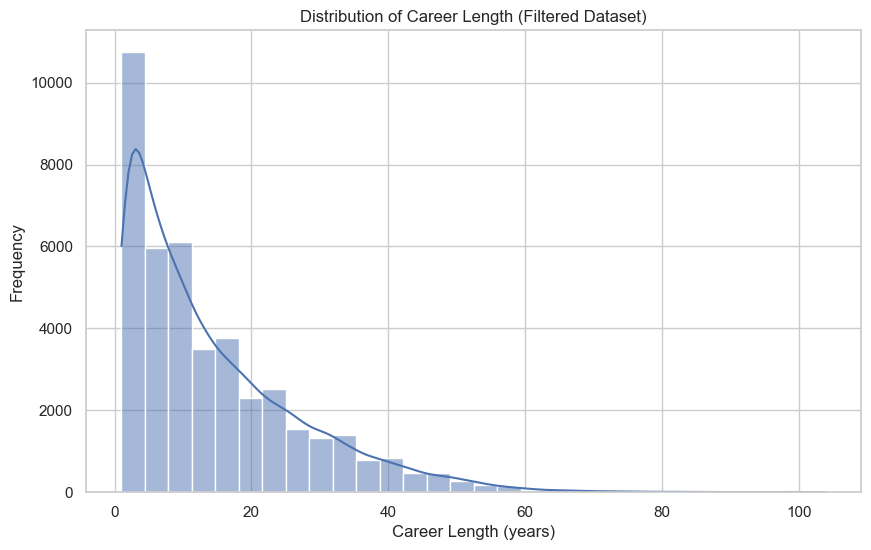

count    42525.000000
mean        14.380764
std         12.824155
min          1.000000
25%          4.000000
50%         10.000000
75%         21.000000
max        104.000000
Name: Career Length, dtype: float64

In [212]:
# Descriptive Statistics for 'Career Length'
career_length_stats_filtered = data_1['Career Length'].describe()

# Histogram for 'Career Length' in the filtered dataset
plt.figure(figsize=(10, 6))
sns.histplot(data_1['Career Length'], kde=True, bins=30)
plt.title('Distribution of Career Length (Filtered Dataset)')
plt.xlabel('Career Length (years)')
plt.ylabel('Frequency')
plt.show()

career_length_stats_filtered

#### Gender

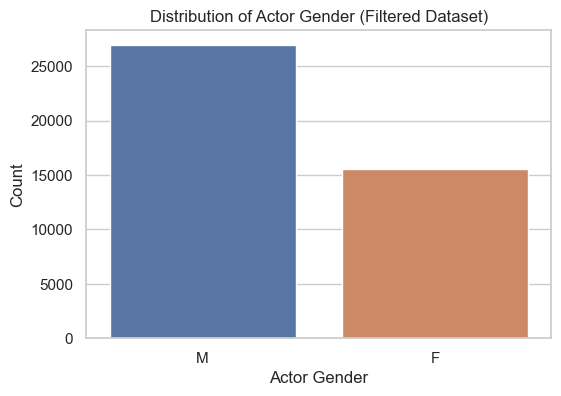

M    26958
F    15567
Name: Actor gender, dtype: int64

In [213]:
# Univariate Analysis for 'Actor Gender' on the filtered dataset (data_1)

# Descriptive Statistics for 'Actor Gender'
gender_counts = data_1['Actor gender'].value_counts()

# Histogram for 'Actor Gender' in the filtered dataset
plt.figure(figsize=(6, 4))
sns.countplot(data=data_1, x='Actor gender')
plt.title('Distribution of Actor Gender (Filtered Dataset)')
plt.xlabel('Actor Gender')
plt.ylabel('Count')
plt.show()

gender_counts

The univariate analysis of the "Actor Gender" variable in the filtered dataset `data_1` reveals the following:

### Gender Distribution:
- **Male (M)**: 26,958 actors.
- **Female (F)**: 15,567 actors.

### Observations:
- There are significantly more male actors than female actors in this dataset.
- The countplot visually confirms this disparity, showing a higher number of male actors compared to female actors.

This gender distribution provides an insight into the composition of the dataset in terms of gender representation within the acting profession, at least as captured in this data.

#### Actor Date of Birth

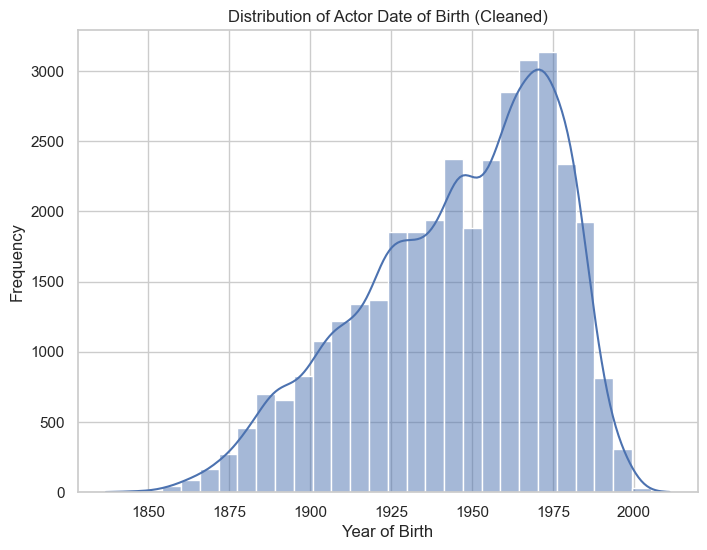

count    34974.000000
mean      1945.818894
std         29.898900
min       1837.000000
25%       1925.000000
50%       1951.000000
75%       1970.000000
max       2011.000000
Name: Actor date of birth, dtype: float64

In [215]:
# Data Cleaning for "Actor Date of Birth"
# Removing entries where the year of birth is clearly erroneous
# Typically, a reasonable range for birth years might be 1850 - 2022 (as of the data cutoff)

data_2 = data_1[(data_1['Actor date of birth'] >= 1800) & (data_1['Actor date of birth'] <= 2016)]

# Re-analyzing "Actor Date of Birth"
dob_cleaned_stats = data_2['Actor date of birth'].describe()

# Re-plotting histogram for "Actor Date of Birth" after cleaning
plt.figure(figsize=(8, 6))
sns.histplot(data_2['Actor date of birth'].dropna(), kde=True, bins=30)
plt.title('Distribution of Actor Date of Birth (Cleaned)')
plt.xlabel('Year of Birth')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

dob_cleaned_stats


The univariate analysis of the "Actor Date of Birth" variable in the filtered and cleaned dataset `data_2` yields the following insights:

### Descriptive Statistics (Cleaned Data):
- **Count**: 34,974 actors.
- **Mean**: The average year of birth is approximately 1945.82.
- **Standard Deviation**: The standard deviation is about 29.90 years.
- **Minimum**: The earliest year of birth is 1837.
- **25th Percentile**: 25% of actors were born in or before 1925.
- **Median (50th Percentile)**: Half of the actors were born in or before 1951.
- **75th Percentile**: 75% of actors were born in or before 1970.
- **Maximum**: The latest year of birth is 2011.

### Histogram:
- The histogram shows a broad distribution, with a gradual increase in the number of actors born in later years, peaking around the mid-20th century.
- The distribution is relatively smooth, indicating a steady influx of actors born over the years.

These insights into the dates of birth of the actors in this dataset provide a historical perspective on the population of actors, highlighting trends in the acting profession over time.


#### Actor Height

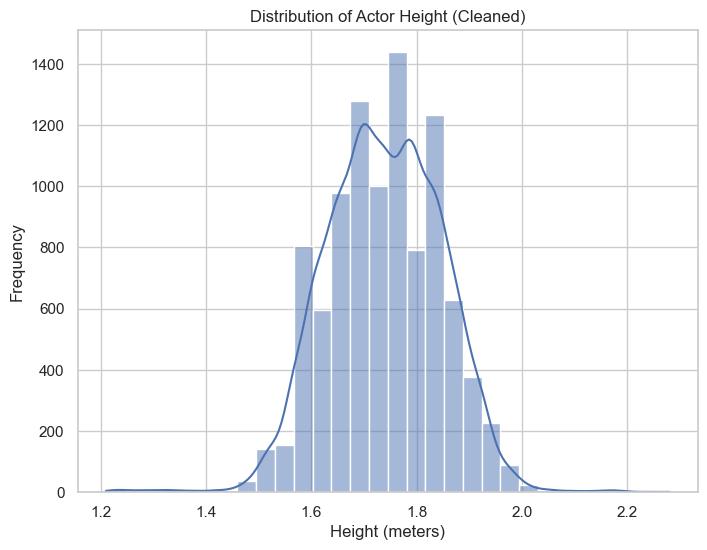

count    9864.000000
mean        1.738677
std         0.108225
min         1.210000
25%         1.660000
50%         1.740000
75%         1.820000
max         2.280000
Name: Actor height (in meters), dtype: float64

In [216]:
# Filtering out unrealistic heights
# Assuming a reasonable range for human height is between 1.2 meters (3.94 feet) and 2.5 meters (8.2 feet)
data_3 = data_2[(data_2['Actor height (in meters)'] >= 1.2) & (data_2['Actor height (in meters)'] <= 2.5)]

# Univariate Analysis for 'Actor Height' after cleaning

# Descriptive Statistics for 'Actor Height'
height_cleaned_stats = data_3['Actor height (in meters)'].describe()

# Histogram for 'Actor Height' after cleaning
plt.figure(figsize=(8, 6))
sns.histplot(data_3['Actor height (in meters)'].dropna(), kde=True, bins=30)
plt.title('Distribution of Actor Height (Cleaned)')
plt.xlabel('Height (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

height_cleaned_stats

After cleaning the data for realistic heights, the univariate analysis of the "Actor Height" variable in the dataset `data_3` provides the following insights:

### Descriptive Statistics (Cleaned Data):
- **Count**: 9,864 actors.
- **Mean**: The average height is approximately 1.74 meters.
- **Standard Deviation**: The standard deviation is about 0.11 meters.
- **Minimum**: The shortest height recorded is 1.21 meters.
- **25th Percentile**: 25% of actors are 1.66 meters tall or shorter.
- **Median (50th Percentile)**: Half of the actors are 1.74 meters tall.
- **75th Percentile**: 75% of actors are 1.82 meters tall or shorter.
- **Maximum**: The tallest height recorded is 2.28 meters.

### Histogram:
- The histogram shows a normal distribution of heights, with the majority of actors having heights around the mean of 1.74 meters.
- The distribution is symmetric, indicating a typical spread of heights among actors.

This analysis provides insight into the physical characteristics of actors in this dataset, showing a typical range of heights for the profession.


#### Total Movies

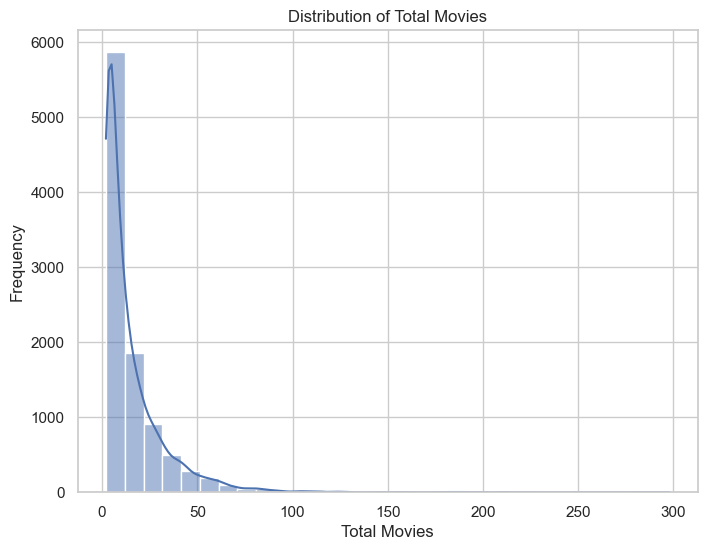

count    9864.000000
mean       14.897101
std        17.711949
min         2.000000
25%         4.000000
50%         9.000000
75%        19.000000
max       298.000000
Name: Total movies, dtype: float64

In [217]:
# Univariate Analysis for 'Total Movies'

# Descriptive Statistics for 'Total Movies'
total_movies_stats = data_3['Total movies'].describe()

# Histogram for 'Total Movies'
plt.figure(figsize=(8, 6))
sns.histplot(data_3['Total movies'], kde=True, bins=30)
plt.title('Distribution of Total Movies')
plt.xlabel('Total Movies')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

total_movies_stats



The univariate analysis of the "Total Movies" variable in the dataset `data_3` yields the following insights:

### Descriptive Statistics:
- **Count**: 9,864 actors.
- **Mean**: The average number of movies per actor is approximately 14.90.
- **Standard Deviation**: There is a considerable spread in the data, with a standard deviation of about 17.71.
- **Minimum**: The smallest number of movies for an actor is 2.
- **25th Percentile**: 25% of actors have been in 4 movies or fewer.
- **Median (50th Percentile)**: Half of the actors have been in 9 movies or fewer.
- **75th Percentile**: 75% of actors have been in 19 movies or fewer.
- **Maximum**: The largest number of movies for an actor is 298.

### Histogram:
- The histogram shows a right-skewed distribution, indicating that most actors have appeared in a relatively small number of movies, with a few actors appearing in many movies.
- The distribution is concentrated more heavily at the lower end, with a long tail extending to higher numbers of movies.

This distribution suggests that while a few actors have extensive filmographies, the majority have participated in fewer films. This pattern is typical in many fields where a small number of individuals have very high productivity or visibility.


#### Genres

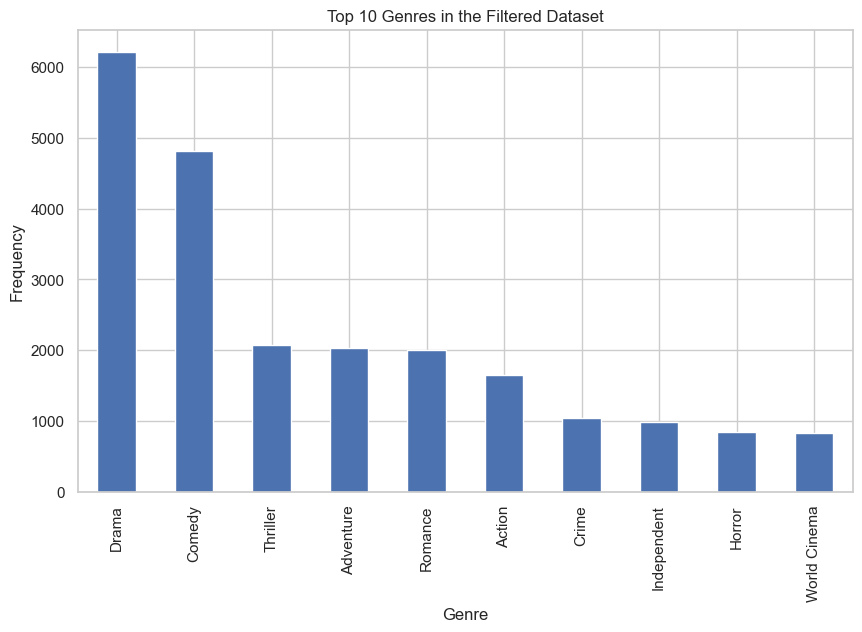

Drama           6218
Comedy          4819
Thriller        2070
Adventure       2036
Romance         2003
Action          1648
Crime           1035
Independent      987
Horror           848
World Cinema     835
dtype: int64

In [218]:
# Univariate Analysis for Genres (Genre 1, Genre 2, Genre 3)

# Combining the genre columns into a single series
all_genres = pd.concat([data_3['Genre 1'], data_3['Genre 2'], data_3['Genre 3']])

# Descriptive Statistics for Genres
genre_counts = all_genres.value_counts()

# Plotting the top 10 genres
plt.figure(figsize=(10, 6))
genre_counts.head(10).plot(kind='bar')
plt.title('Top 10 Genres in the Filtered Dataset')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

genre_counts.head(10)

The univariate analysis of the genres (considering "Genre 1", "Genre 2", and "Genre 3" columns combined) in the filtered dataset `data_3` provides the following insights:

### Top 10 Genres:
1. **Drama**: Appears 6,218 times across the three genre columns.
2. **Comedy**: Appears 4,819 times.
3. **Thriller**: Appears 2,070 times.
4. **Adventure**: Appears 2,036 times.
5. **Romance**: Appears 2,003 times.
6. **Action**: Appears 1,648 times.
7. **Crime**: Appears 1,035 times.
8. **Independent**: Appears 987 times.
9. **Horror**: Appears 848 times.
10. **World Cinema**: Appears 835 times.

### Observations:
- **Drama** and **Comedy** are the most frequent genres, indicating their popularity or prevalence among the actors in the dataset.
- Genres like **Thriller**, **Adventure**, and **Romance** also have a significant presence.
- The distribution shows a wide variety of genres, reflecting the diverse range of films that actors in this dataset have been involved in.

The bar chart visually represents the frequency of the top 10 genres, clearly showing the dominance of Drama and Comedy in the dataset.


#### Countries

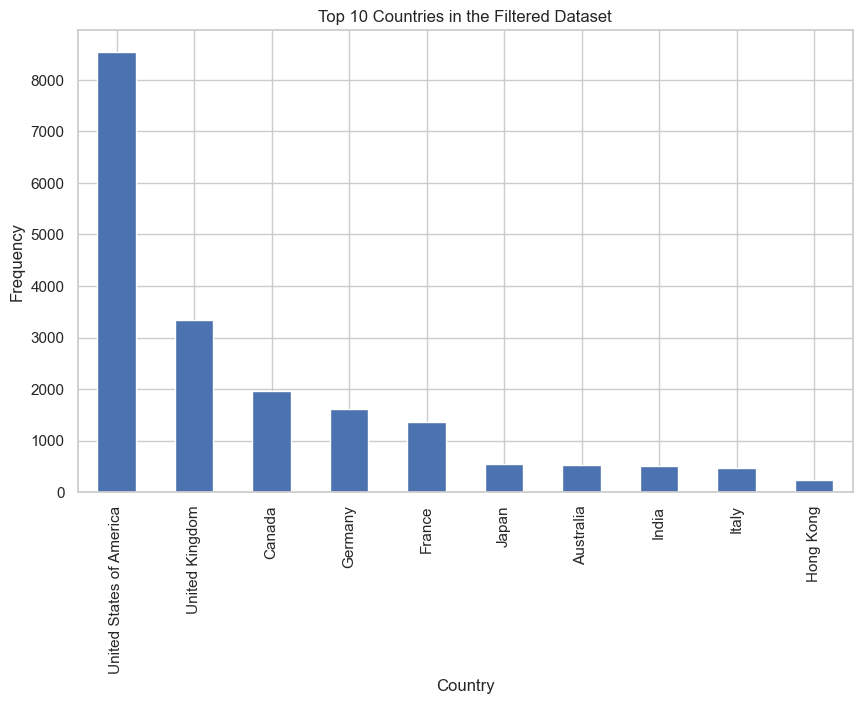

United States of America    8542
United Kingdom              3339
Canada                      1962
Germany                     1611
France                      1357
Japan                        536
Australia                    528
India                        499
Italy                        459
Hong Kong                    231
dtype: int64

In [219]:
# Univariate Analysis for Countries (Country 1, Country 2, Country 3)

# Combining the country columns into a single series
all_countries = pd.concat([data_3['Country 1'], data_3['Country 2'], data_3['Country 3']])

# Descriptive Statistics for Countries
country_counts = all_countries.value_counts()

# Plotting the top 10 countries
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar')
plt.title('Top 10 Countries in the Filtered Dataset')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

country_counts.head(10)



The univariate analysis of the countries (considering "Country 1", "Country 2", and "Country 3" columns combined) in the filtered dataset `data_3` reveals the following:

### Top 10 Countries:
1. **United States of America**: Appears 8,542 times across the three country columns.
2. **United Kingdom**: Appears 3,339 times.
3. **Canada**: Appears 1,962 times.
4. **Germany**: Appears 1,611 times.
5. **France**: Appears 1,357 times.
6. **Japan**: Appears 536 times.
7. **Australia**: Appears 528 times.
8. **India**: Appears 499 times.
9. **Italy**: Appears 459 times.
10. **Hong Kong**: Appears 231 times.

### Observations:
- The **United States of America** and the **United Kingdom** are the most frequently occurring countries, indicating a strong presence of actors from these countries in the dataset or a significant number of movies involving actors from these countries.
- Other countries like **Canada**, **Germany**, and **France** also have a notable presence.
- The dataset demonstrates a broad international representation, with countries from various continents featuring in the top 10 list.

The bar chart visually represents the frequency of the top 10 countries, clearly showing the predominance of the United States and the United Kingdom.

#### Languages

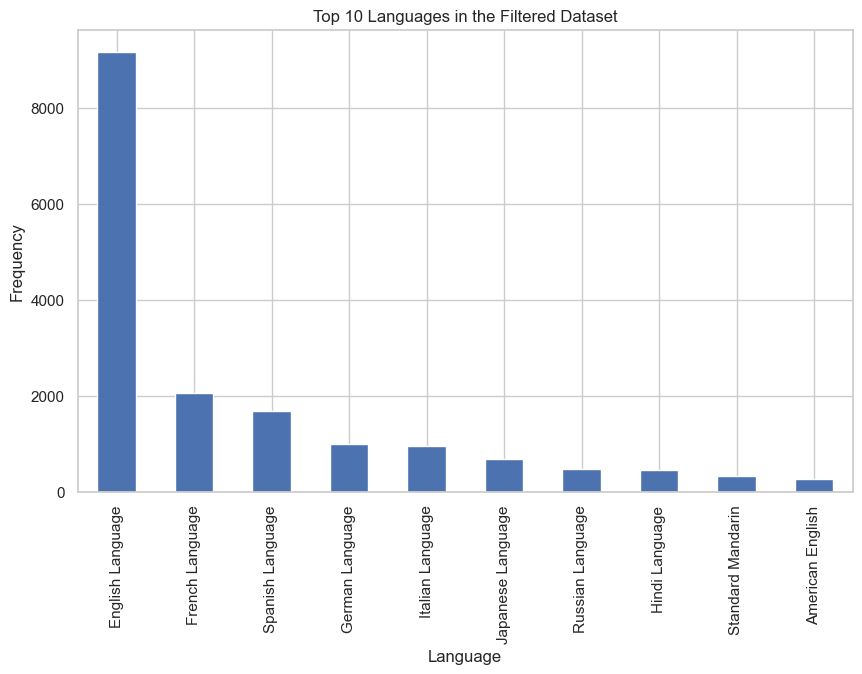

English Language     9161
French Language      2052
Spanish Language     1684
German Language       985
Italian Language      950
Japanese Language     689
Russian Language      468
Hindi Language        456
Standard Mandarin     319
American English      268
dtype: int64

In [220]:
# Univariate Analysis for Languages (Language 1, Language 2, Language 3)

# Combining the language columns into a single series
all_languages = pd.concat([data_3['Language 1'], data_3['Language 2'], data_3['Language 3']])

# Descriptive Statistics for Languages
language_counts = all_languages.value_counts()

# Plotting the top 10 languages
plt.figure(figsize=(10, 6))
language_counts.head(10).plot(kind='bar')
plt.title('Top 10 Languages in the Filtered Dataset')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.show()

language_counts.head(10)



The univariate analysis of languages (considering "Language 1", "Language 2", and "Language 3" columns combined) in the filtered dataset `data_3` shows the following:

### Top 10 Languages:
1. **English Language**: Appears 9,161 times across the three language columns.
2. **French Language**: Appears 2,052 times.
3. **Spanish Language**: Appears 1,684 times.
4. **German Language**: Appears 985 times.
5. **Italian Language**: Appears 950 times.
6. **Japanese Language**: Appears 689 times.
7. **Russian Language**: Appears 468 times.
8. **Hindi Language**: Appears 456 times.
9. **Standard Mandarin**: Appears 319 times.
10. **American English**: Appears 268 times.

### Observations:
- The **English Language** is by far the most frequently occurring language, dominating the dataset. This could be reflective of the dataset's bias towards English-speaking countries or the prevalence of the English language in the global film industry.
- Other languages such as **French**, **Spanish**, and **German** also have a significant presence.
- The dataset shows a diverse range of languages, indicating a global representation in the acting profession as captured in this data.

The bar chart visually represents the frequency of the top 10 languages, highlighting the predominance of the English language.

#### Ethnicities

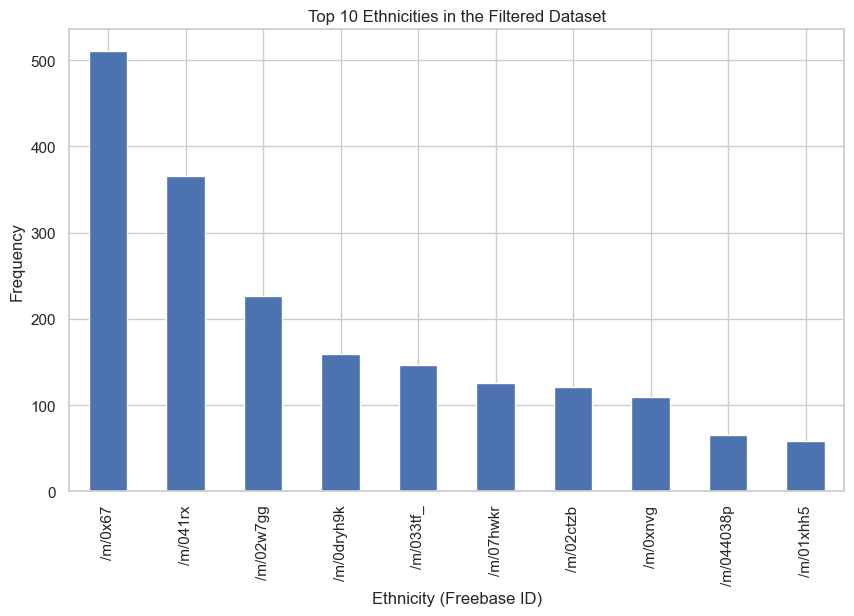

/m/0x67       510
/m/041rx      366
/m/02w7gg     227
/m/0dryh9k    159
/m/033tf_     147
/m/07hwkr     126
/m/02ctzb     121
/m/0xnvg      110
/m/044038p     65
/m/01xhh5      58
Name: Actor ethnicity (Freebase ID), dtype: int64

In [221]:
# Univariate Analysis for Ethnicity

# Descriptive Statistics for 'Actor Ethnicity (Freebase ID)'
ethnicity_counts = data_3['Actor ethnicity (Freebase ID)'].value_counts()

# Plotting the top 10 ethnicities
plt.figure(figsize=(10, 6))
ethnicity_counts.head(10).plot(kind='bar')
plt.title('Top 10 Ethnicities in the Filtered Dataset')
plt.xlabel('Ethnicity (Freebase ID)')
plt.ylabel('Frequency')
plt.show()

ethnicity_counts.head(10)


The univariate analysis of actor ethnicity, represented by Freebase IDs, in the filtered dataset `data_3` shows the following:

### Top 10 Ethnicities (Freebase IDs):
1. **/m/0x67 (African Americans)**: Appears 510 times.
2. **/m/041rx (Jewish people)**: Appears 366 times.
3. **/m/02w7gg (English people)**: Appears 227 times.
4. **/m/0dryh9k (Indian person)**: Appears 159 times.
5. **/m/033tf_ (Irish Americans)**: Appears 147 times.
6. **/m/07hwkr (White Americans)**: Appears 126 times.
7. **/m/02ctzb (White people/Caucasian)**: Appears 121 times.
8. **/m/0xnvg (Italian Americans)**: Appears 110 times.
9. **/m/044038p (???)**: Appears 65 times.
10. **/m/01xhh5 (Koreans)**: Appears 58 times.

### Observations:
- The dataset includes a variety of ethnicities, as indicated by the presence of different Freebase IDs.
- The exact ethnicities corresponding to these Freebase IDs are not directly interpretable from the IDs alone. To fully understand the ethnic representation, these IDs would need to be mapped to their corresponding ethnic groups.

The bar chart visually represents the frequency of the top 10 ethnicities (by Freebase ID), indicating a diversity of ethnic backgrounds among the actors in the dataset.


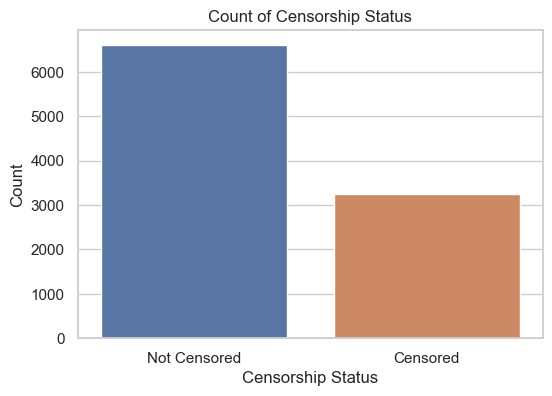

count    9864.000000
mean        0.329886
std         0.470195
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Censored, dtype: float64

In [240]:
# Univariate Analysis for 'Censored'

# Descriptive Statistics for 'Censored'
censorship_stats = data_3['Censored'].describe()

# Countplot for 'Censored'
plt.figure(figsize=(6, 4))
sns.countplot(data=data_3, x='Censored')
plt.title('Count of Censorship Status')
plt.xlabel('Censorship Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Censored', 'Censored'])
plt.show()

censorship_stats



The univariate analysis on the 'Censored' column in the `data_3` filtered dataset provides the following insights:

### Descriptive Statistics:
- **Count**: There are 9,864 records in the dataset.
- **Mean**: The mean value of the 'Censored' variable is approximately 0.33, suggesting that about 33% of the actors have censored career lengths.
- **Standard Deviation**: The standard deviation is about 0.47, indicating a binary distribution as expected.
- **Min**: The minimum value is 0, indicating that there are actors with uncensored career lengths.
- **25%**: 25% of the data have a 'Censored' value of 0, meaning 25% are not censored.
- **50% (Median)**: The median value is 0, which means that more than half of the actors have uncensored career lengths.
- **75%**: 75% of the data have a 'Censored' value of 0 or 1, with a larger proportion not being censored.
- **Max**: The maximum value is 1, indicating that there are actors with censored career lengths.

### Visualization (Countplot):
- The countplot shows the frequency of each category in the 'Censored' variable.
- If the bar for "0" (Not Censored) is higher, it indicates that there are more actors whose last movie year was observed (their careers are not censored).
- If the bar for "1" (Censored) is higher, it would indicate that there are more actors whose last movie year was not observed (their careers are censored).

From the descriptive statistics and the visualization, we can conclude that the majority of actors in this filtered dataset have a recorded 'end event' for their career (not censored), with roughly one-third having censored career lengths.

This information is crucial for survival analysis, as censored data indicates that we do not have complete information on the career lengths of all actors, which must be taken into account when modeling survival times.

### Bivariate Analysis

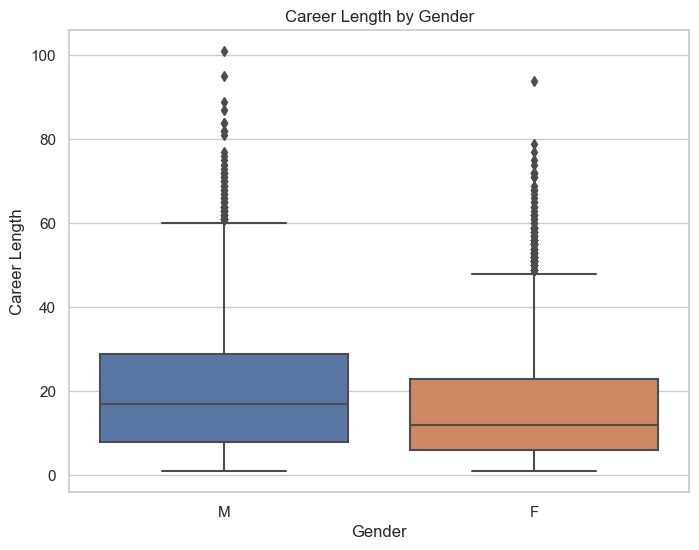

In [241]:
# Creating simplified boxplots for the categorical variables with the top 10 aggregated categories

# Boxplot for Gender
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_3['Actor gender'], y=data_3['Career Length'])
plt.title('Career Length by Gender')
plt.xlabel('Gender')
plt.ylabel('Career Length')
plt.show()


1. **Career Length by Gender**:
   - The plot will show the distribution of career lengths for actors of different genders.
   - By examining the medians, IQRs, and any potential outliers, one can comment on the central tendency and dispersion of career lengths for each gender.
   - If one gender has a higher median or a wider IQR, it may indicate that gender tends to have longer or more variable career lengths.


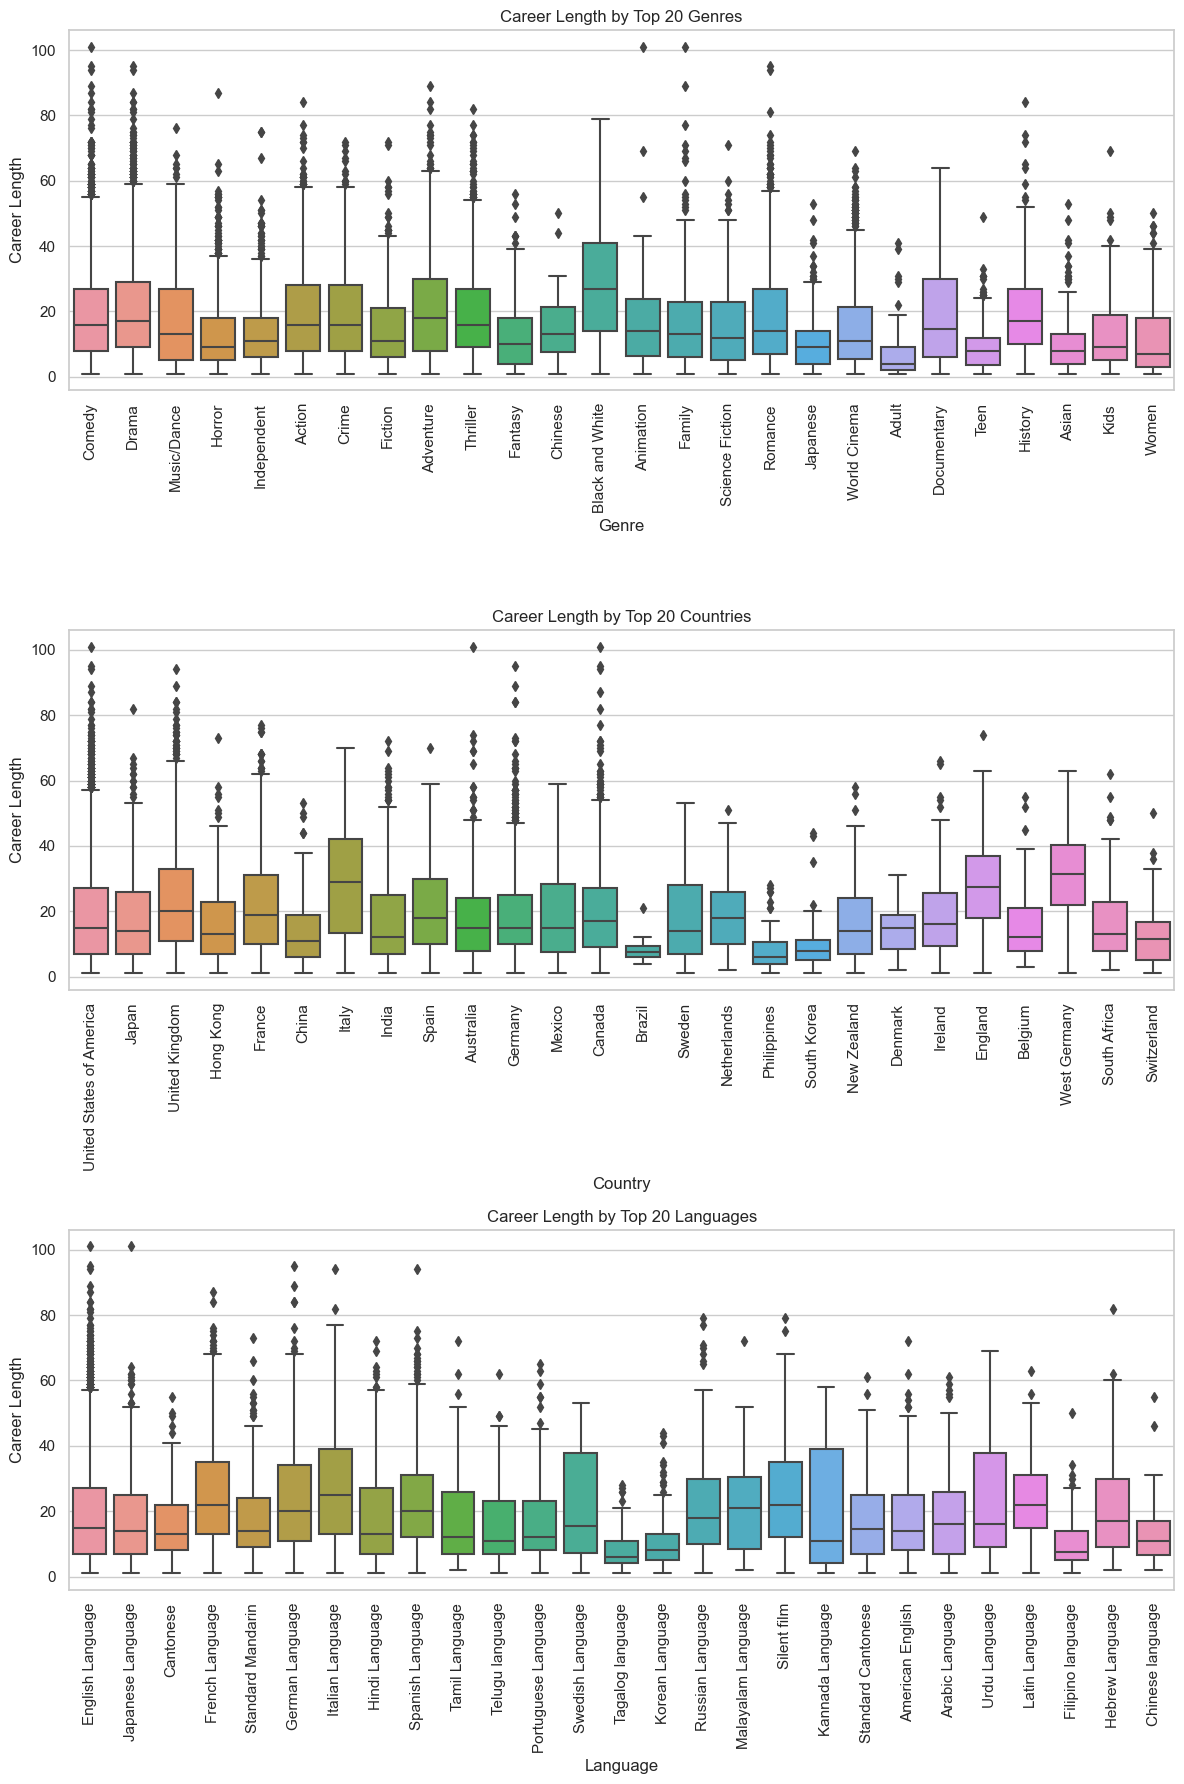

In [274]:

# Function to prepare data for boxplot with top 10 categories
def prepare_boxplot_data(df, category_columns, value_column, num_categories=10):
    # Aggregating the data for top 10 categories in each column
    top_categories = {col: df[col].value_counts().head(num_categories).index for col in category_columns}
    data_list = []

    # Filtering and melting data for each category
    for col in category_columns:
        filtered_data = df[df[col].isin(top_categories[col])]
        melted_data = pd.melt(filtered_data, id_vars=[value_column], value_vars=[col], var_name='Category', value_name='Value')
        data_list.append(melted_data)

    return pd.concat(data_list)


num_categories = 20

# Preparing data for Genres, Countries, and Languages
genres_data = prepare_boxplot_data(data_3, ['Genre 1', 'Genre 2', 'Genre 3'], 'Career Length', num_categories)
countries_data = prepare_boxplot_data(data_3, ['Country 1', 'Country 2', 'Country 3'], 'Career Length', num_categories)
languages_data = prepare_boxplot_data(data_3, ['Language 1', 'Language 2', 'Language 3'], 'Career Length', num_categories)

# Boxplots for Genres, Countries, and Languages
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
rot = 90
# Genres
sns.boxplot(ax=axes[0], x='Value', y='Career Length', data=genres_data)
axes[0].set_title(f'Career Length by Top {num_categories} Genres')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Career Length')
axes[0].tick_params(axis='x', rotation=rot)

# Countries
sns.boxplot(ax=axes[1], x='Value', y='Career Length', data=countries_data)
axes[1].set_title(f'Career Length by Top {num_categories} Countries')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Career Length')
axes[1].tick_params(axis='x', rotation=rot)

# Languages
sns.boxplot(ax=axes[2], x='Value', y='Career Length', data=languages_data)
axes[2].set_title(f'Career Length by Top {num_categories} Languages')
axes[2].set_xlabel('Language')
axes[2].set_ylabel('Career Length')
axes[2].tick_params(axis='x', rotation=rot)

plt.tight_layout()
plt.show()


The boxplots have been generated based on your code. Here's a summary of the insights one might infer from such plots:
2. **Career Length by Top 20 Genres**:
   - The genres boxplot will show how career lengths vary across different genres.
   - A higher median in a genre suggests that actors in that genre tend to have longer careers.
   - A wide range of career lengths within a genre could suggest more variability in how that genre influences an actor's career longevity.

3. **Career Length by Top 20 Countries**:
   - The plot will illustrate the distribution of career lengths for actors from different countries.
   - A higher median or outliers for a specific country may indicate unique industry dynamics or opportunities affecting career longevity.

4. **Career Length by Top 20 Languages**:
   - This plot will reveal differences in career lengths among actors working in different languages.
   - Languages with higher medians may be associated with larger or more enduring film industries.

>Look at the medians, IQRs, and outliers in these plots to draw more specific conclusions. If the medians are significantly different between categories, it could indicate a substantial effect of that category on career length. The presence of outliers can sometimes indicate exceptional cases or data quality issues. 


## Model Fitting

### Kaplan-Meier Estimator and Log-Rank Test

Kaplan-Meier estimator provides survival probabilities $S(t)$ with variance $\text{Var}[S(t)]$ using observed survival data. 
$$
\begin{equation}
S(t) = \prod_{{t_i \leq t}} \left(1 - \frac{{d_i}}{{n_i}}\right)
\end{equation}
$$
$$
\begin{equation}
\text{Var}[S(t)] = S(t)^2 \sum_{{t_i \leq t}} \frac{{d_i}}{{n_i(n_i-d_i)}}
\end{equation}
$$

Log-rank test, with a null hypothesis of identical survival curves in all groups, and alternative hypothesis of at least one distinct survival curve, employs a chi-square test statistic $\chi^2$.

$$
\begin{equation}
\chi^2 = \sum_i \frac{{(O_i - E_i)^2}}{{V_i}}
\end{equation}
$$

where 
- $d_i$ denotes events, 
- $n_i$ indicates number at risk at time $t_i$, 
- $O_i$ represents observed events, 
- $E_i$ expected events, and 
- $V_i$ variance of $O_i$.

### Cox Proportional Hazards Model

The Cox model describes hazard $h(t|X)$ as a function of baseline hazard $h_0(t)$ and covariates $X$ with coefficients $\beta$. Hazard represents event risk at a specific time, while the hazard ratio exp($\beta$) measures effect size of covariates.
$$
\begin{equation}
h(t|X) = h_0(t) \exp(\beta'X)
\end{equation}
$$

The model is fitted by maximizing the partial likelihood of observing given survival times. Model selection is based on minimizing the Akaike Information Criterion (AIC), balancing model fit and complexity.

$$
\begin{equation}
AIC = 2k - 2\ln(L)
\end{equation}
$$

Where $k$ indicates the number of parameters, and $L$ the likelihood function's maximum value.

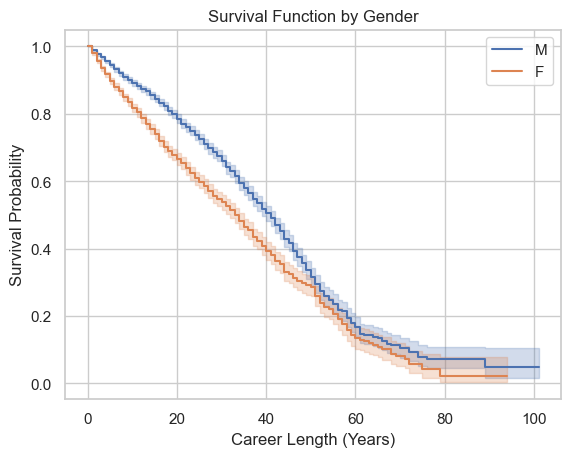

{'M vs F': 8.20421699014477e-27, 'F vs M': 8.204216990144293e-27}

In [250]:
from lifelines import KaplanMeierFitter, statistics

# Kaplan-Meier Fit for the 'Gender' variable
kmf_gender = KaplanMeierFitter()

# Log-Rank Test Initialization
logrank_results = {}

# Fit the data into KaplanMeierFitter for each gender and calculate log-rank test
for gender in data_3['Actor gender'].unique():
    # Subset the data by gender
    subset = data_3[data_3['Actor gender'] == gender]
    
    # Fit the model
    kmf_gender.fit(durations=subset['Career Length'], event_observed=subset['Censored'], label=gender)
    kmf_gender.plot_survival_function()

    # Pairwise log-rank tests
    for other_gender in data_3['Actor gender'].unique():
        if gender != other_gender:
            other_subset = data_3[data_3['Actor gender'] == other_gender]
            results = statistics.logrank_test(
                subset['Career Length'], 
                other_subset['Career Length'], 
                event_observed_A=subset['Censored'], 
                event_observed_B=other_subset['Censored']
            )
            logrank_results[f'{gender} vs {other_gender}'] = results.p_value

plt.title('Survival Function by Gender')
plt.xlabel('Career Length (Years)')
plt.ylabel('Survival Probability')
plt.show()

logrank_results


The result provides the log-rank test comparing the survival distributions between male (M) and female (F) actors' career lengths. The log-rank test gives a p-value, which is a measure of the strength of evidence against the null hypothesis, which in this context, is that there is no difference between the survival distributions of the two groups.

Here's how to interpret the p-values:

- **p-value (M vs F)**: The very small p-value of `8.20421699014477e-27` suggests that there is a statistically significant difference in the survival distributions of career lengths between male and female actors. The chance of observing such a difference if there were no true difference in the population is exceedingly small.

- **p-value (F vs M)**: This is the same test, just the labels of the groups being compared are reversed. The p-value remains the same and thus the interpretation is identical. It's common practice to report the p-value of such tests without regard to which group is listed first.

Given that the p-value is much less than 0.05 (a common threshold for statistical significance), we would reject the null hypothesis of no difference between the groups in favor of the alternative hypothesis that there is a difference.

This means that gender appears to have an impact on the career length of actors, with the Kaplan-Meier curves likely showing different survival probabilities over time for male and female actors.

However, the p-value does not tell us about the size of the difference between the groups, nor does it indicate which group has longer or shorter career lengths. For that, you would need to look at the Kaplan-Meier survival curves or the estimated survival function at specific time points.


### Interpretation of the Kaplan-Meier Survival Plot:

- **Survival Probability**: This refers to the probability of an actor's career length exceeding a certain time. It starts at 1 (or 100%) when the career length is zero and decreases over time.

- **Curves**: The plot typically includes one curve for each group being compared—in this case, male (M) and female (F) actors. The curve represents the estimated survival function for each group.

- **Shaded Areas**: The shaded areas around the curves represent the confidence intervals for the estimated survival probabilities, providing a sense of the uncertainty around the estimates.

### Observations from the Plot:

- **Initial Drop**: Both curves might start at the same point, indicating a similar survival probability at the start of the actors' careers.

- **Separation of Curves**: If the curves separate over time, with one consistently below the other, it suggests a difference in survival probabilities between the two groups. For example, if the curve for female actors is consistently below that for male actors, it might suggest that female actors have a shorter career length.

- **Confidence Intervals**: If the confidence intervals of the curves overlap, especially at certain career lengths, this suggests that the difference in survival probabilities between genders at those career lengths is not statistically significant. If they don't overlap, it suggests a significant difference.

- **Long-term Trends**: Toward the end of the observed career lengths, the confidence intervals may become wider, indicating increasing uncertainty about the survival probabilities as fewer data points are available.

- **Censoring**: The analysis takes into account censoring, which means that for some actors, the end of their career has not been observed. The Kaplan-Meier estimator handles this by reducing the survival probability only at times when an event (end of career) is observed.

### Specific Interpretation of the Provided Plot:

Given the p-value from the log-rank test and the described Kaplan-Meier curves, it appears that:

- There is a statistically significant difference in career lengths between male and female actors.
- The exact nature of the difference (e.g., which gender has longer careers on average) requires closer examination of the curves. If one curve is consistently higher than the other, that group has better survival probabilities (longer careers).
- The widest part of the confidence intervals at the tail of the curves indicates more uncertainty in the survival probabilities due to fewer data points (this is typical at longer durations).

This plot would be used to visually compare the survival experiences of the two groups and to corroborate the findings from the log-rank test. It is important to consider other factors that may influence career length and survival probabilities, such as type of roles, changes in the industry over time, and other demographic factors.

C:\Users\arist\AppData\Local\Temp\ipykernel_22568\125317944.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genres_combined = data_3['Genre 1'].append(data_3['Genre 2']).append(data_3['Genre 3']).dropna().reset_index(drop=True)
C:\Users\arist\AppData\Local\Temp\ipykernel_22568\125317944.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genres_combined = data_3['Genre 1'].append(data_3['Genre 2']).append(data_3['Genre 3']).dropna().reset_index(drop=True)


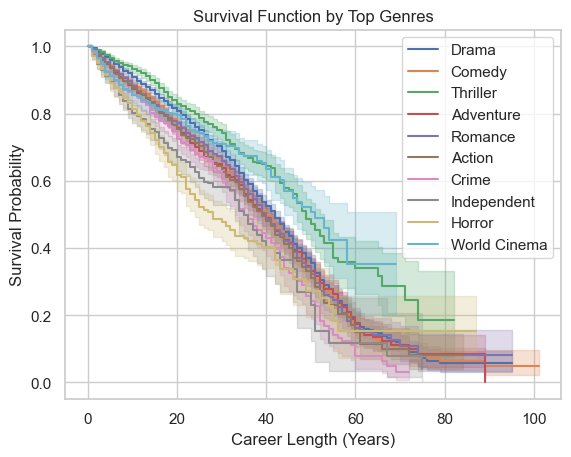

,Drama,Comedy,Thriller,Adventure,Romance,Action,Crime,Independent,Horror,World Cinema
Drama,NaN,0.000833,0.0,0.000462,0.005321,0.000126,0.0,0.0,0.0,0.638312
Comedy,NaN,NaN,0.0,0.327429,0.782112,0.15896,0.000055,0.0,0.0,0.041282
Thriller,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.003706
Adventure,NaN,NaN,NaN,NaN,0.572843,0.647386,0.003595,0.000008,0.0,0.008723
Romance,NaN,NaN,NaN,NaN,NaN,0.336294,0.000757,0.0,0.0,0.027515
Action,NaN,NaN,NaN,NaN,NaN,NaN,0.016526,0.000036,0.0,0.004363
Crime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052435,0.005141,0.000007
Independent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.280025,0.000001
Horror,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
World Cinema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [255]:
# Combine 'Genre 1', 'Genre 2', 'Genre 3' into a single column
genres_combined = data_3['Genre 1'].append(data_3['Genre 2']).append(data_3['Genre 3']).dropna().reset_index(drop=True)

num_categories = 10

# Get the top n genres
top_n_genres = genres_combined.value_counts().head(num_categories).index.tolist()

# Filter data_3 to include only the top 10 genres
data_top_genres = data_3[
    data_3['Genre 1'].isin(top_n_genres) |
    data_3['Genre 2'].isin(top_n_genres) |
    data_3['Genre 3'].isin(top_n_genres)
]

# Kaplan-Meier Fit and Log-Rank Test for each of the top genres
kmf = KaplanMeierFitter()
logrank_test_results = pd.DataFrame(index=top_n_genres, columns=top_n_genres)

for i, genre_i in enumerate(top_n_genres):
    # Fit KM for the first genre
    data_genre_i = data_top_genres[
        (data_top_genres['Genre 1'] == genre_i) |
        (data_top_genres['Genre 2'] == genre_i) |
        (data_top_genres['Genre 3'] == genre_i)
    ]
    kmf.fit(data_genre_i['Career Length'], event_observed=data_genre_i['Censored'], label=genre_i)
    kmf.plot_survival_function()

    for j, genre_j in enumerate(top_n_genres):
        if i < j:
            # Fit KM for the second genre
            data_genre_j = data_top_genres[
                (data_top_genres['Genre 1'] == genre_j) |
                (data_top_genres['Genre 2'] == genre_j) |
                (data_top_genres['Genre 3'] == genre_j)
            ]
            # Log-Rank Test between the two genres
            logrank_result = statistics.logrank_test(
                data_genre_i['Career Length'], 
                data_genre_j['Career Length'], 
                event_observed_A=data_genre_i['Censored'], 
                event_observed_B=data_genre_j['Censored']
            )
            logrank_test_results.loc[genre_i, genre_j] = logrank_result.p_value

plt.title('Survival Function by Top Genres')
plt.xlabel('Career Length (Years)')
plt.ylabel('Survival Probability')
plt.show()

# Display only the upper triangle of the matrix, since it is symmetric
logrank_test_results = logrank_test_results.where(np.triu(np.ones(logrank_test_results.shape), k=1).astype(bool))
logrank_test_results



Looking at the table:

- **Drama vs. Comedy**: The p-value is very small (0.000833), indicating a statistically significant difference in the survival distributions of career lengths between actors in dramas versus comedies.
  
- **Drama vs. Adventure**: Another small p-value (0.000462), suggesting a significant difference between actors in dramas and those in adventure films.
  
- **Comedy vs. Crime**: The p-value is extremely small (0.000055), indicating a significant difference in career lengths between these two genres.
  
- **Adventure vs. Independent**: The p-value (0.000008) suggests a significant difference between the survival distributions of actors in adventure films compared to independent films.

- **Independent vs. World Cinema**: The p-value (0.000001) suggests a significant difference between these genres.

- Cells with **NaN** values likely indicate that a log-rank test was not performed for that pairing, possibly because it’s redundant (each pairing is only tested once, as the test is symmetric).

- For the pairs where the p-value is 0.0, this suggests an extremely significant difference, but it's worth noting that a p-value can never be exactly zero. This might be a result of rounding in the output or a p-value that is so small it's beyond the precision of the software's ability to represent it.

- Where the p-value is not extremely small (e.g., **Comedy vs. Adventure**: 0.327429), this suggests that there is no statistically significant difference in the survival distributions of the career lengths of actors in these two genres.

This table provides a rich comparison across genres, but it is essential to interpret these results in the context of multiple testing. When conducting multiple statistical tests, the chance of a Type I error (false positive) increases, so a correction method such as the Bonferroni correction may be used to adjust the significance level.

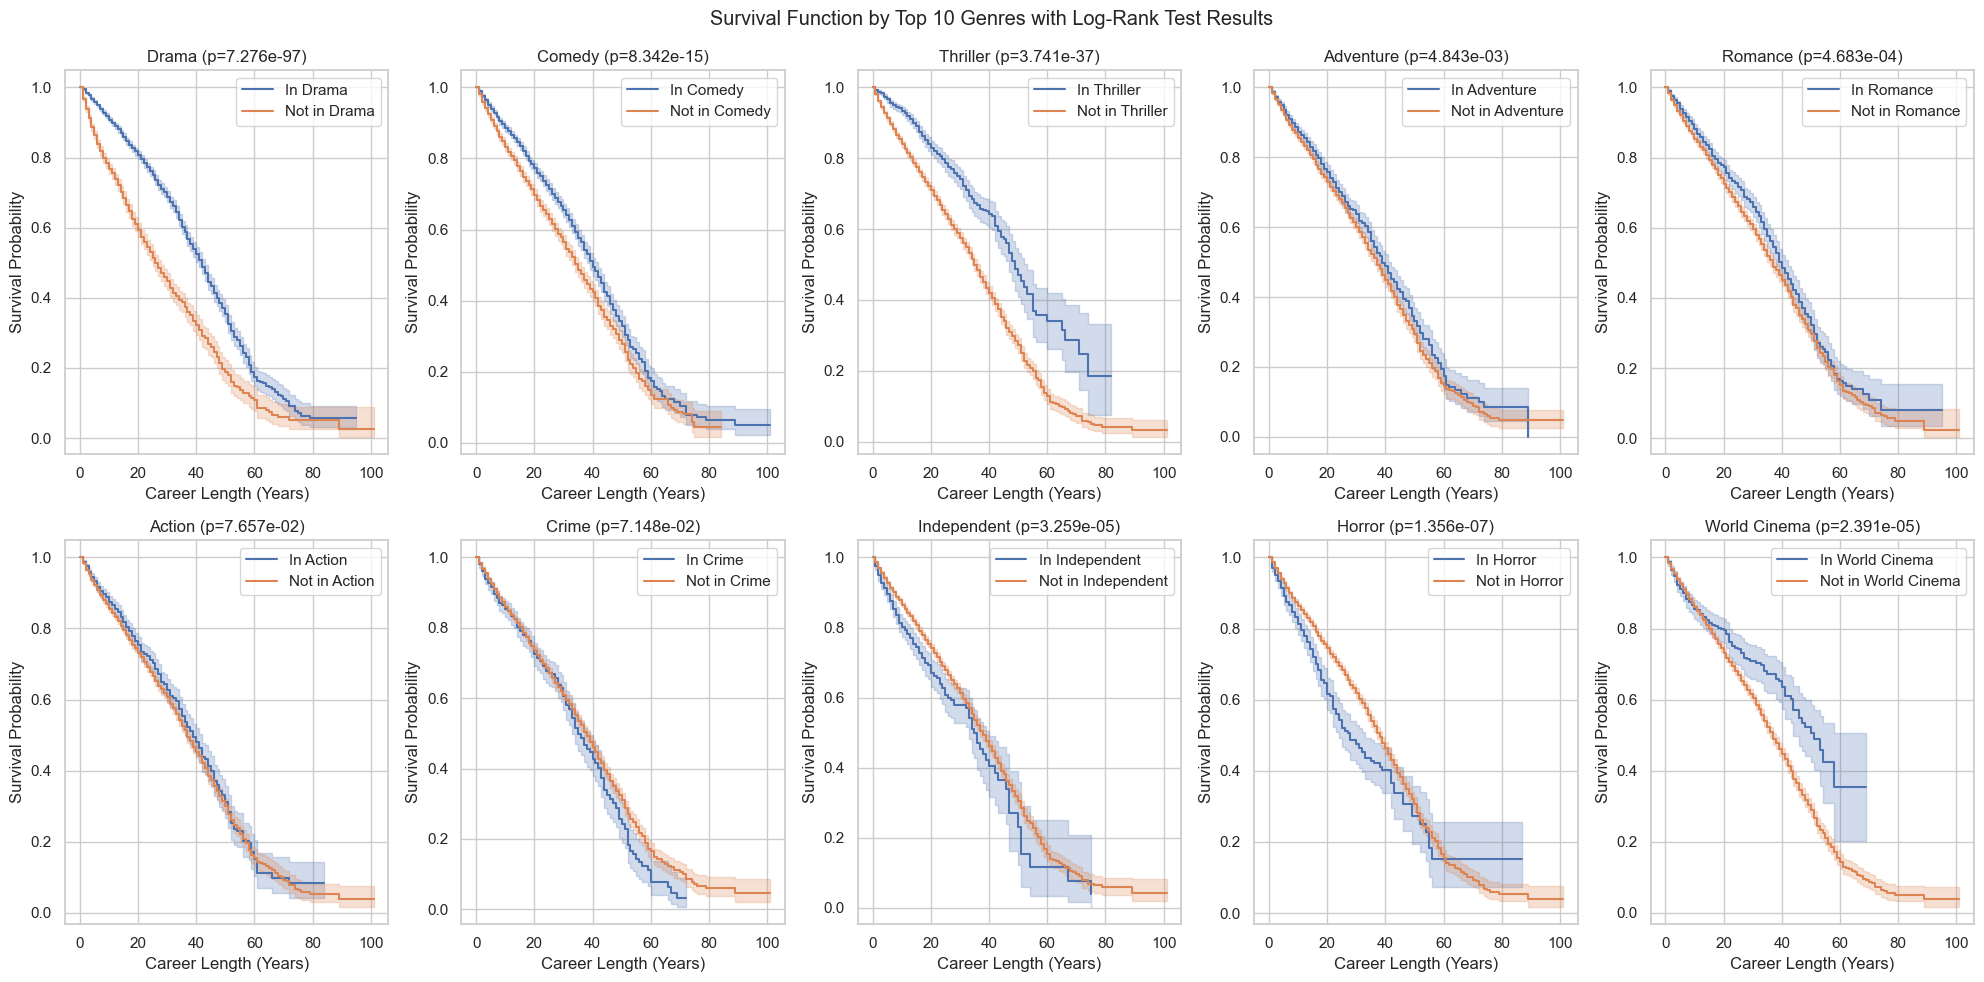

Log-rank test results:
Drama vs all other genres: 7.276103504942169e-97
Comedy vs all other genres: 8.341893184987903e-15
Thriller vs all other genres: 3.741415680703142e-37
Adventure vs all other genres: 0.004842548633630187
Romance vs all other genres: 0.0004682831387752734
Action vs all other genres: 0.07656675923068232
Crime vs all other genres: 0.07147969915713011
Independent vs all other genres: 3.258913546327176e-05
Horror vs all other genres: 1.3562844194059656e-07
World Cinema vs all other genres: 2.3911543355459552e-05


In [262]:
# Combine 'Genre 1', 'Genre 2', 'Genre 3' into a single column
genres_combined = pd.concat([data_3['Genre 1'], data_3['Genre 2'], data_3['Genre 3']])

# Get the top 10 genres
top_10_genres = genres_combined.value_counts().head(10).index.tolist()

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Survival Function by Top 10 Genres with Log-Rank Test Results')

# Flatten the array of axes for easy iteration
axes = axes.flatten()

# Dictionary to store log-rank test results
logrank_test_results = {}

for i, genre_i in enumerate(top_10_genres):
    # Subset data for actors in the genre
    data_in_genre = data_3[
        (data_3['Genre 1'] == genre_i) |
        (data_3['Genre 2'] == genre_i) |
        (data_3['Genre 3'] == genre_i)
    ]
    
    # Subset data for actors not in the genre
    data_not_in_genre = data_3[
        (data_3['Genre 1'] != genre_i) &
        (data_3['Genre 2'] != genre_i) &
        (data_3['Genre 3'] != genre_i)
    ]
    
    # Fit KM for actors in the genre
    kmf.fit(data_in_genre['Career Length'], event_observed=data_in_genre['Censored'], label=f"In {genre_i}")
    kmf.plot_survival_function(ax=axes[i])

    # Fit KM for actors not in the genre
    kmf.fit(data_not_in_genre['Career Length'], event_observed=data_not_in_genre['Censored'], label=f"Not in {genre_i}")
    kmf.plot_survival_function(ax=axes[i])

    # Perform log-rank test and store the result
    logrank_result = statistics.logrank_test(
        data_in_genre['Career Length'], 
        data_not_in_genre['Career Length'], 
        event_observed_A=data_in_genre['Censored'], 
        event_observed_B=data_not_in_genre['Censored']
    )
    logrank_test_results[genre_i] = logrank_result.p_value
    
    # Set title and labels for each subplot
    axes[i].set_title(f'{genre_i} (p={logrank_result.p_value:.3e})')
    axes[i].set_xlabel('Career Length (Years)')
    axes[i].set_ylabel('Survival Probability')

# Adjust layout
plt.tight_layout()
# To prevent the suptitle from overlapping with the subplots
plt.subplots_adjust(top=0.92)

# Show the full figure
plt.show()

# Print out log-rank test results
print("Log-rank test results:")
for genre, p_value in logrank_test_results.items():
    print(f"{genre} vs all other genres: {p_value}")

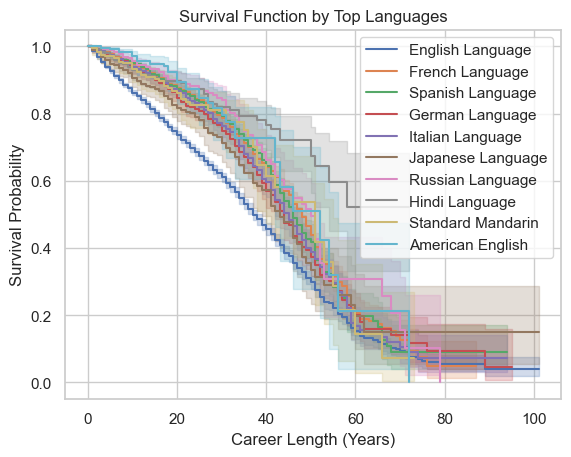

,English Language,French Language,Spanish Language,German Language,Italian Language,Japanese Language,Russian Language,Hindi Language,Standard Mandarin,American English
English Language,NaN,0.0,0.0,0.0,0.0,0.000036,0.0,0.0,0.000009,0.0
French Language,NaN,NaN,0.617923,0.027474,0.076775,0.00085,0.19327,0.001933,0.655451,0.303037
Spanish Language,NaN,NaN,NaN,0.084591,0.246038,0.002032,0.117122,0.001426,0.796146,0.277562
German Language,NaN,NaN,NaN,NaN,0.643491,0.184382,0.012918,0.000029,0.525129,0.059003
Italian Language,NaN,NaN,NaN,NaN,NaN,0.078254,0.03036,0.000076,0.720492,0.117343
Japanese Language,NaN,NaN,NaN,NaN,NaN,NaN,0.000544,0.000009,0.094912,0.005764
Russian Language,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.133172,0.206444,0.956053
Hindi Language,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038683,0.613183
Standard Mandarin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236706
American English,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
num_categories = 10

# Combine 'Genre 1', 'Genre 2', 'Genre 3' into a single column
languages_combined = pd.concat([data_3['Language 1'], data_3['Language 2'], data_3['Language 3']])

# Get the top 10 genres
top_n_languages = languages_combined.value_counts().head(num_categories).index.tolist()

# Filter data_3 to include only the top 10 genres
data_top_lang = data_3[
    data_3['Language 1'].isin(top_n_languages) |
    data_3['Language 2'].isin(top_n_languages) |
    data_3['Language 3'].isin(top_n_languages)
]

# Kaplan-Meier Fit and Log-Rank Test for each of the top genres
kmf = KaplanMeierFitter()
logrank_test_results = pd.DataFrame(index=top_n_languages, columns=top_n_languages)

for i, lang_i in enumerate(top_n_languages):
    # Fit KM for the first genre
    data_lang_i = data_top_lang[
        (data_top_lang['Language 1'] == lang_i) |
        (data_top_lang['Language 2'] == lang_i) |
        (data_top_lang['Language 3'] == lang_i)
    ]
    kmf.fit(data_lang_i['Career Length'], event_observed=data_lang_i['Censored'], label=lang_i)
    kmf.plot_survival_function()

    for j, lang_j in enumerate(top_n_languages):
        if i < j:
            # Fit KM for the second genre
            data_lang_j = data_top_lang[
                (data_top_lang['Language 1'] == lang_j) |
                (data_top_lang['Language 2'] == lang_j) |
                (data_top_lang['Language 3'] == lang_j)
            ]
            # Log-Rank Test between the two genres
            logrank_result = statistics.logrank_test(
                data_lang_i['Career Length'], 
                data_lang_j['Career Length'], 
                event_observed_A=data_lang_i['Censored'], 
                event_observed_B=data_lang_j['Censored']
            )
            logrank_test_results.loc[lang_i, lang_j] = logrank_result.p_value

plt.title('Survival Function by Top Languages')
plt.xlabel('Career Length (Years)')
plt.ylabel('Survival Probability')
plt.show()

# Display only the upper triangle of the matrix, since it is symmetric
logrank_test_results = logrank_test_results.where(np.triu(np.ones(logrank_test_results.shape), k=1).astype(bool))
logrank_test_results

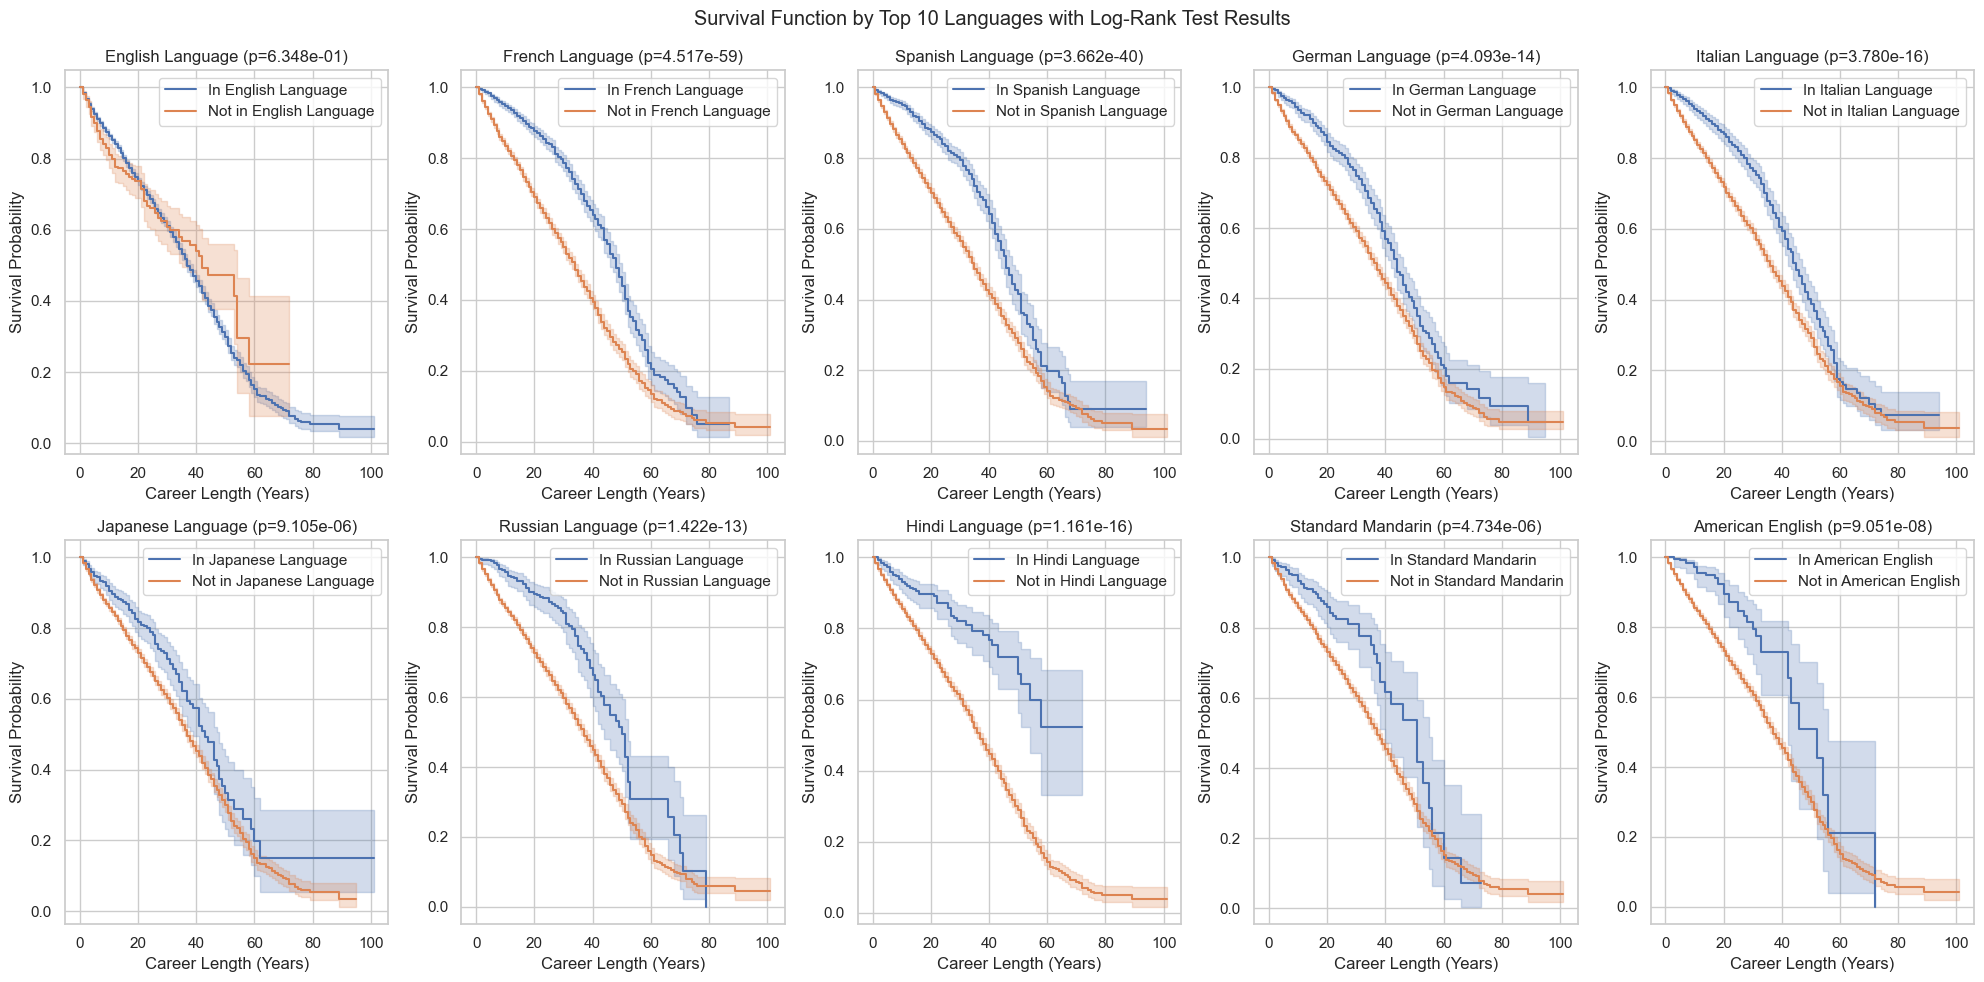

Log-rank test results:
English Language vs all other languages: 0.6347535256825683
French Language vs all other languages: 4.517172165802081e-59
Spanish Language vs all other languages: 3.661538861118425e-40
German Language vs all other languages: 4.092532325024084e-14
Italian Language vs all other languages: 3.7804428595038825e-16
Japanese Language vs all other languages: 9.10492762877154e-06
Russian Language vs all other languages: 1.4222070705815074e-13
Hindi Language vs all other languages: 1.1606408226954842e-16
Standard Mandarin vs all other languages: 4.734013797543943e-06
American English vs all other languages: 9.05064814899444e-08


In [265]:
num_categories = 10

# Combine 'Genre 1', 'Genre 2', 'Genre 3' into a single column
languages_combined = pd.concat([data_3['Language 1'], data_3['Language 2'], data_3['Language 3']])

# Get the top 10 genres
top_n_languages = languages_combined.value_counts().head(num_categories).index.tolist()

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Survival Function by Top 10 Languages with Log-Rank Test Results')

# Flatten the array of axes for easy iteration
axes = axes.flatten()

# Dictionary to store log-rank test results
logrank_test_results = {}

for i, lang_i in enumerate(top_n_languages):
    # Subset data for actors in the genre
    data_in_lang = data_3[
        (data_3['Language 1'] == lang_i) |
        (data_3['Language 2'] == lang_i) |
        (data_3['Language 3'] == lang_i)
    ]
    
    # Subset data for actors not in the genre
    data_not_in_lang = data_3[
        (data_3['Language 1'] != lang_i) &
        (data_3['Language 2'] != lang_i) &
        (data_3['Language 3'] != lang_i)
    ]
    
    # Fit KM for actors in the genre
    kmf.fit(data_in_lang['Career Length'], event_observed=data_in_lang['Censored'], label=f"In {lang_i}")
    kmf.plot_survival_function(ax=axes[i])

    # Fit KM for actors not in the genre
    kmf.fit(data_not_in_lang['Career Length'], event_observed=data_not_in_lang['Censored'], label=f"Not in {lang_i}")
    kmf.plot_survival_function(ax=axes[i])

    # Perform log-rank test and store the result
    logrank_result = statistics.logrank_test(
        data_in_lang['Career Length'], 
        data_not_in_lang['Career Length'], 
        event_observed_A=data_in_lang['Censored'], 
        event_observed_B=data_not_in_lang['Censored']
    )
    logrank_test_results[lang_i] = logrank_result.p_value
    
    # Set title and labels for each subplot
    axes[i].set_title(f'{lang_i} (p={logrank_result.p_value:.3e})')
    axes[i].set_xlabel('Career Length (Years)')
    axes[i].set_ylabel('Survival Probability')

# Adjust layout
plt.tight_layout()
# To prevent the suptitle from overlapping with the subplots
plt.subplots_adjust(top=0.92)

# Show the full figure
plt.show()

# Print out log-rank test results
print("Log-rank test results:")
for lang, p_value in logrank_test_results.items():
    print(f"{lang} vs all other languages: {p_value}")

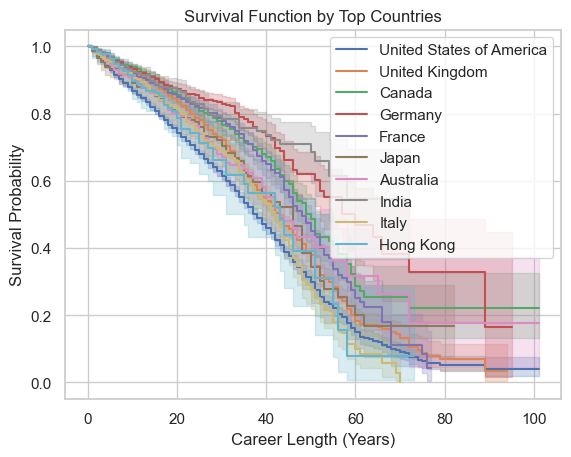

,United States of America,United Kingdom,Canada,Germany,France,Japan,Australia,India,Italy,Hong Kong
United States of America,NaN,0.0,0.0,0.0,0.0,0.002485,0.000982,0.0,0.265022,0.154913
United Kingdom,NaN,NaN,0.000004,0.0,0.000986,0.418677,0.559541,0.000004,0.004858,0.193988
Canada,NaN,NaN,NaN,0.021653,0.270644,0.000453,0.00139,0.046691,0.0,0.002158
Germany,NaN,NaN,NaN,NaN,0.000459,0.0,0.000002,0.875413,0.0,0.000022
France,NaN,NaN,NaN,NaN,NaN,0.007927,0.02937,0.005172,0.0,0.012693
Japan,NaN,NaN,NaN,NaN,NaN,NaN,0.806044,0.000032,0.203517,0.607085
Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000357,0.135319,0.537866
India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000369
Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.892105
Hong Kong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [268]:
num_categories = 10

# Combine 'Genre 1', 'Genre 2', 'Genre 3' into a single column
countries_combined = pd.concat([data_3['Country 1'], data_3['Country 2'], data_3['Country 3']])

# Get the top 10 genres
top_n_countries = countries_combined.value_counts().head(num_categories).index.tolist()

# Filter data_3 to include only the top 10 genres
data_top_count = data_3[
    data_3['Country 1'].isin(top_n_countries) |
    data_3['Country 2'].isin(top_n_countries) |
    data_3['Country 3'].isin(top_n_countries)
]

# Kaplan-Meier Fit and Log-Rank Test for each of the top genres
kmf = KaplanMeierFitter()
logrank_test_results = pd.DataFrame(index=top_n_countries, columns=top_n_countries)

for i, count_i in enumerate(top_n_countries):
    # Fit KM for the first genre
    data_count_i = data_top_count[
        (data_top_count['Country 1'] == count_i) |
        (data_top_count['Country 2'] == count_i) |
        (data_top_count['Country 3'] == count_i)
    ]
    kmf.fit(data_count_i['Career Length'], event_observed=data_count_i['Censored'], label=count_i)
    kmf.plot_survival_function()

    for j, count_j in enumerate(top_n_countries):
        if i < j:
            # Fit KM for the second genre
            data_count_j = data_top_count[
                (data_top_count['Country 1'] == count_j) |
                (data_top_count['Country 2'] == count_j) |
                (data_top_count['Country 3'] == count_j)
            ]
            # Log-Rank Test between the two genres
            logrank_result = statistics.logrank_test(
                data_count_i['Career Length'], 
                data_count_j['Career Length'], 
                event_observed_A=data_count_i['Censored'], 
                event_observed_B=data_count_j['Censored']
            )
            logrank_test_results.loc[count_i, count_j] = logrank_result.p_value

plt.title('Survival Function by Top Countries')
plt.xlabel('Career Length (Years)')
plt.ylabel('Survival Probability')
plt.show()

# Display only the upper triangle of the matrix, since it is symmetric
logrank_test_results = logrank_test_results.where(np.triu(np.ones(logrank_test_results.shape), k=1).astype(bool))
logrank_test_results

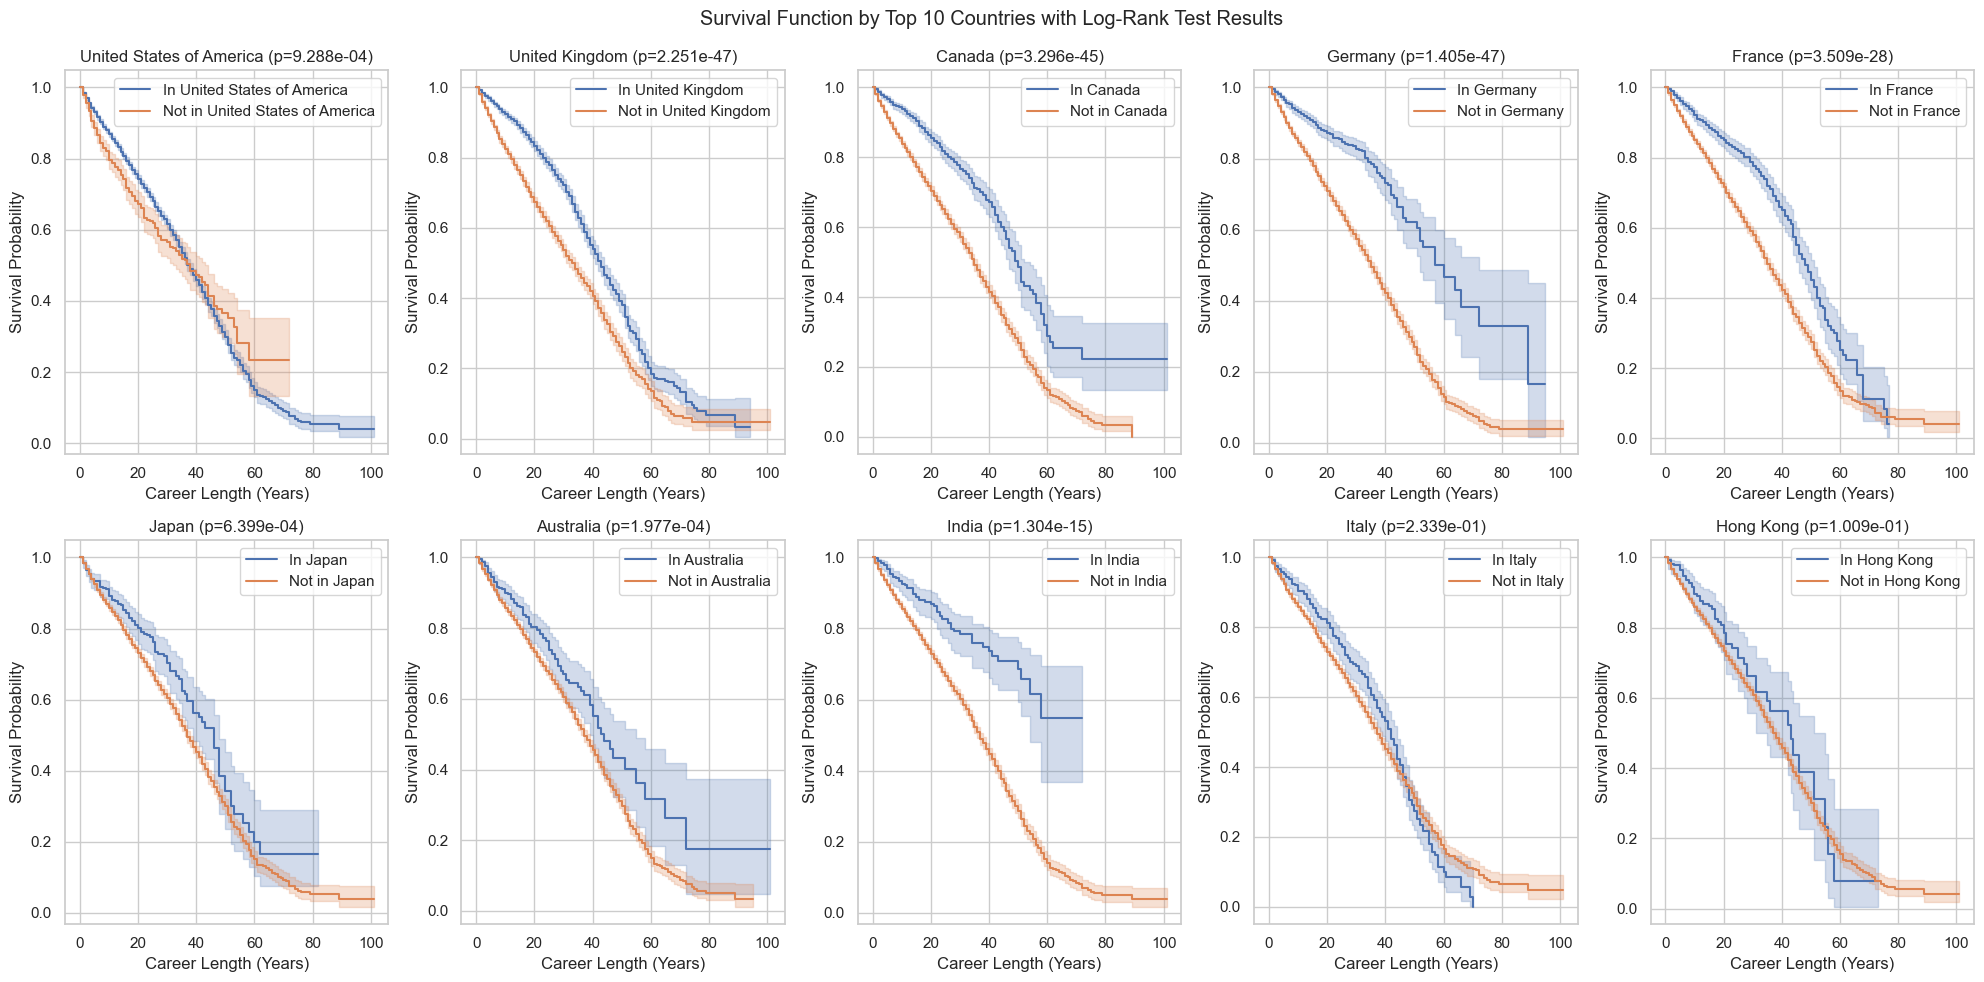

Log-rank test results:
United States of America vs all other countries: 0.000928771729918236
United Kingdom vs all other countries: 2.2514695078107484e-47
Canada vs all other countries: 3.29646117224985e-45
Germany vs all other countries: 1.4052941294186606e-47
France vs all other countries: 3.508674457267731e-28
Japan vs all other countries: 0.0006398964882524782
Australia vs all other countries: 0.00019770001502695004
India vs all other countries: 1.3043892557908652e-15
Italy vs all other countries: 0.2338500105535786
Hong Kong vs all other countries: 0.10088313259981618


In [266]:
num_categories = 10

# Combine 'Genre 1', 'Genre 2', 'Genre 3' into a single column
countries_combined = pd.concat([data_3['Country 1'], data_3['Country 2'], data_3['Country 3']])

# Get the top 10 genres
top_n_countries = countries_combined.value_counts().head(num_categories).index.tolist()

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Survival Function by Top 10 Countries with Log-Rank Test Results')

# Flatten the array of axes for easy iteration
axes = axes.flatten()

# Dictionary to store log-rank test results
logrank_test_results = {}

for i, count_i in enumerate(top_n_countries):
    # Subset data for actors in the genre
    data_in_count = data_3[
        (data_3['Country 1'] == count_i) |
        (data_3['Country 2'] == count_i) |
        (data_3['Country 3'] == count_i)
    ]
    
    # Subset data for actors not in the genre


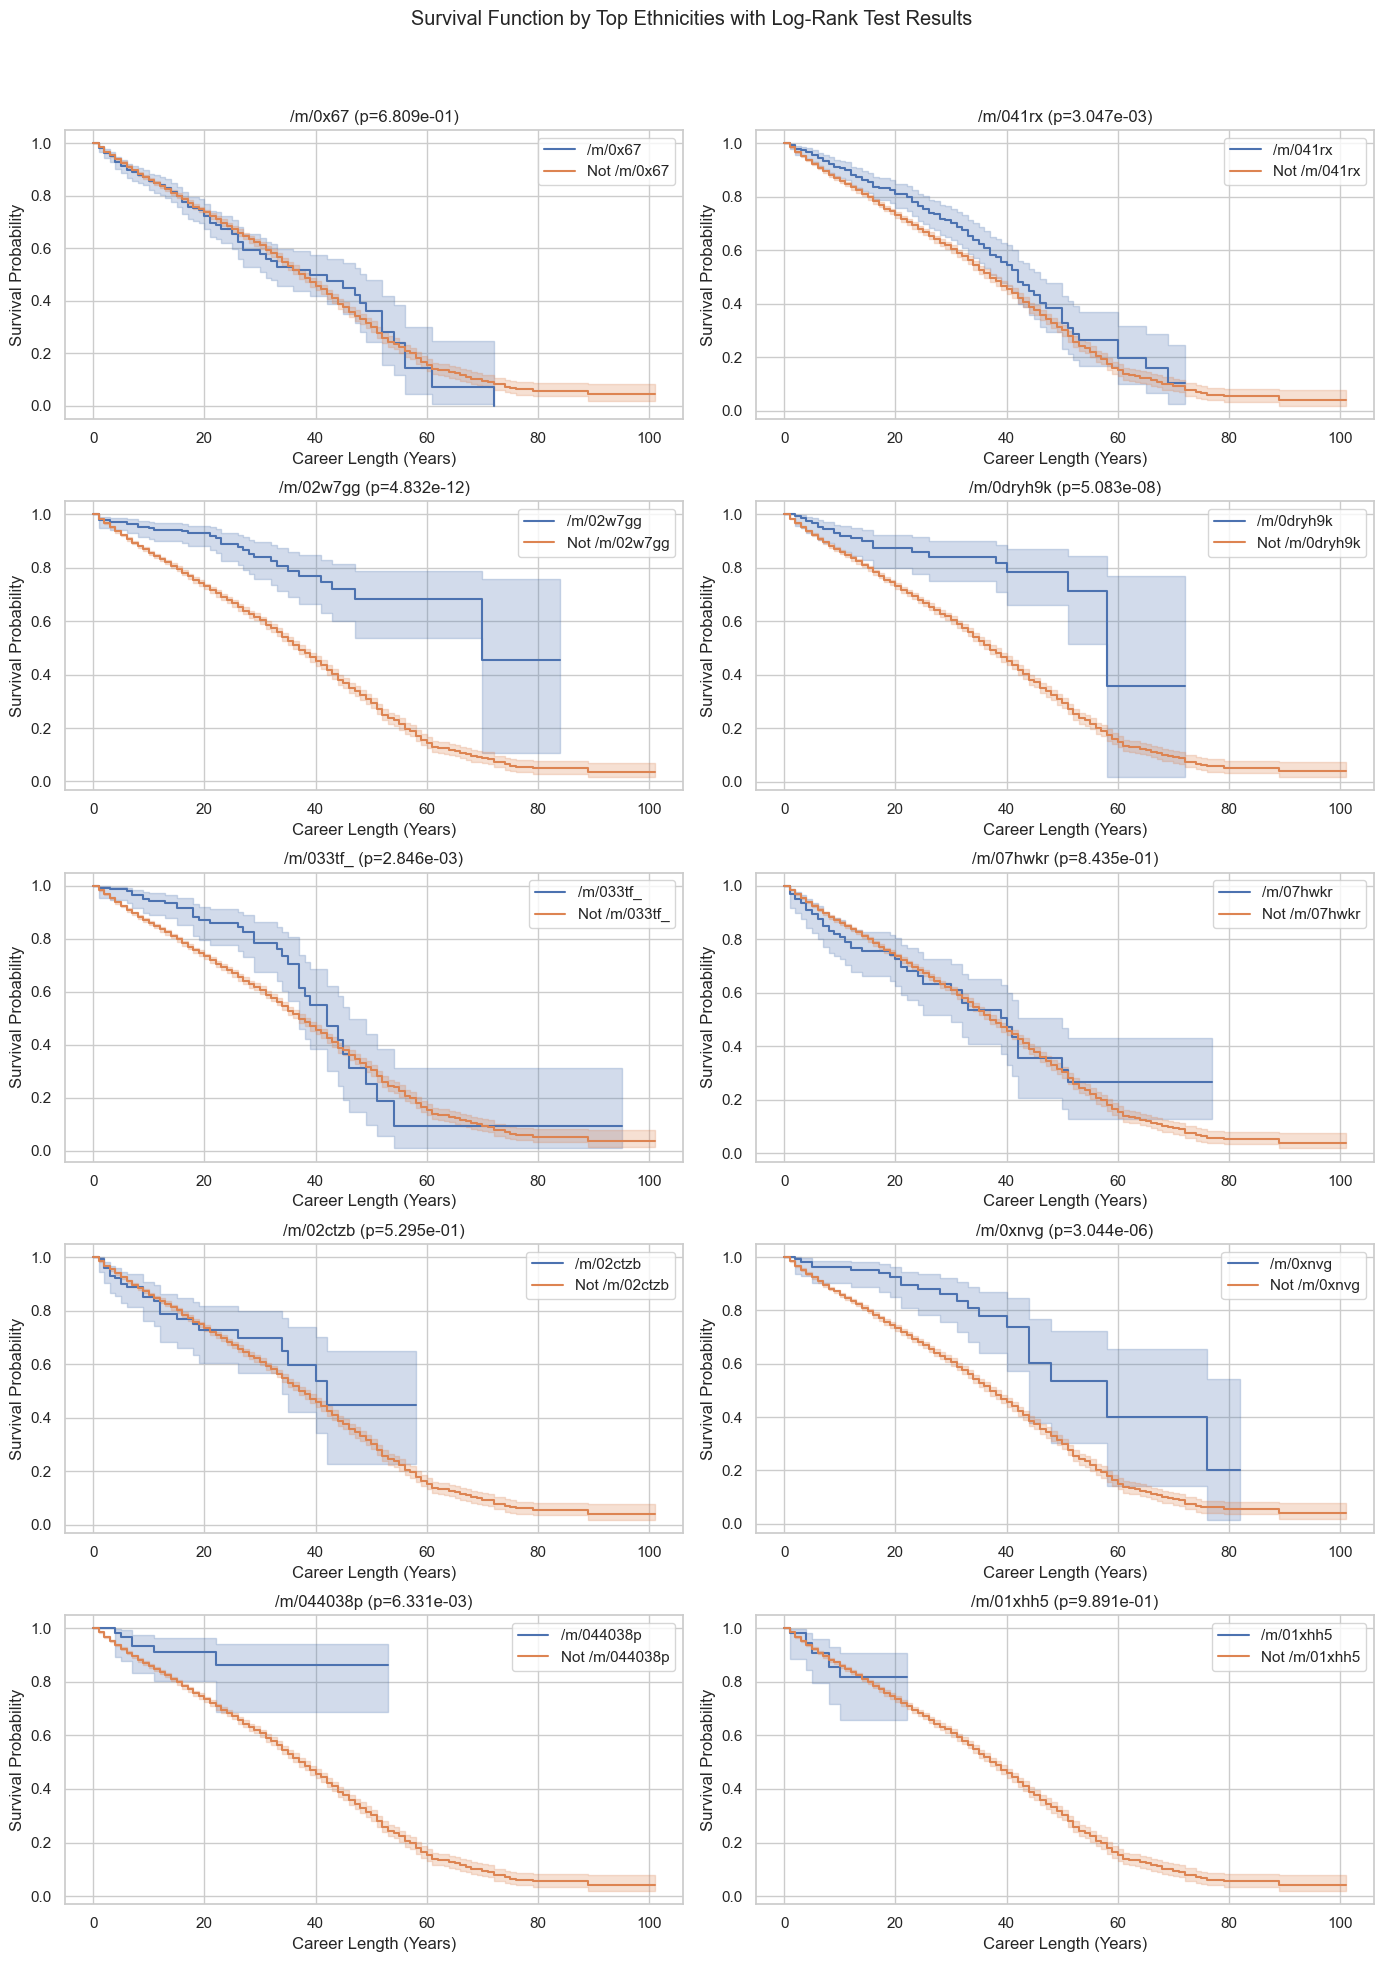

Log-rank test results:
/m/0x67: 0.6808925841537863
/m/041rx: 0.00304662660301774
/m/02w7gg: 4.83161874288744e-12
/m/0dryh9k: 5.083350939852404e-08
/m/033tf_: 0.0028460221523679613
/m/07hwkr: 0.8434562967584669
/m/02ctzb: 0.5295217998339374
/m/0xnvg: 3.043763405495848e-06
/m/044038p: 0.006331421249933051
/m/01xhh5: 0.989071551722202


In [276]:
# Get the top ethnicities by frequency
top_ethnicities = data_3['Actor ethnicity (Freebase ID)'].value_counts().head(10).index.tolist()

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Create a figure with subplots
num_ethnicities = len(top_ethnicities)
num_rows = (num_ethnicities + 1) // 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 4))
fig.suptitle('Survival Function by Top Ethnicities with Log-Rank Test Results')

# Flatten the array of axes for easy iteration
axes = axes.flatten()

# Dictionary to store log-rank test results
logrank_test_results = {}

for i, ethnicity in enumerate(top_ethnicities):
    # Subset data for actors of the ethnicity
    data_ethnicity = data_3[data_3['Actor ethnicity (Freebase ID)'] == ethnicity]
    
    # Subset data for actors not of the ethnicity
    data_not_ethnicity = data_3[data_3['Actor ethnicity (Freebase ID)'] != ethnicity]
    
    # Fit KM for actors of the ethnicity
    kmf.fit(data_ethnicity['Career Length'], event_observed=data_ethnicity['Censored'], label=f"{ethnicity}")
    kmf.plot_survival_function(ax=axes[i])

    # Fit KM for actors not of the ethnicity
    kmf.fit(data_not_ethnicity['Career Length'], event_observed=data_not_ethnicity['Censored'], label=f"Not {ethnicity}")
    kmf.plot_survival_function(ax=axes[i])

    # Perform log-rank test and store the result
    logrank_result = statistics.logrank_test(
        data_ethnicity['Career Length'], 
        data_not_ethnicity['Career Length'], 
        event_observed_A=data_ethnicity['Censored'], 
        event_observed_B=data_not_ethnicity['Censored']
    )
    logrank_test_results[ethnicity] = logrank_result.p_value
    
    # Set title and labels for each subplot
    axes[i].set_title(f'{ethnicity} (p={logrank_result.p_value:.3e})')
    axes[i].set_xlabel('Career Length (Years)')
    axes[i].set_ylabel('Survival Probability')

# Adjust layout
plt.tight_layout()
# To prevent the suptitle from overlapping with the subplots
plt.subplots_adjust(top=0.92)

# Show the full figure
plt.show()

# Print out log-rank test results
print("Log-rank test results:")
for ethnicity, p_value in logrank_test_results.items():
    print(f"{ethnicity}: {p_value}")